# Análisis de Indicadores de Rendimiento

**Objetivo:** Evaluar el rendimiento de la aplicación mediante el análisis de métricas clave extraídas de la base de datos.

Este reporte transforma los datos crudos en información accionable para identificar:
1. Tendencias de uso.
2. Estructura del contenido educativo.
3. Niveles de engagement de los usuarios.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Opcional: Para gráficos más estéticos

# Configuración de estilo
plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
try:
    droped_df = pd.read_csv("P20242_Inst_1_clean.csv")
    print("Datos cargados correctamente.")
    print(f"Registros totales: {droped_df.shape[0]}")
except FileNotFoundError:
    print("Error: El archivo 'cleaned_data.csv' no se encuentra.")

Datos cargados correctamente.
Registros totales: 1162146


## 1. Resumen de Métricas Globales
Vista general del volumen de usuarios y contenido disponible en la plataforma.

In [3]:
# Cálculos básicos
unique = droped_df[['page', 'artifact']].drop_duplicates().reset_index(drop=True)
total_artifacts = unique.groupby('page').size().reset_index(name='artifact_count')
unique_pages = droped_df[['chapter', 'page']].drop_duplicates().reset_index(drop=True)
total_pages_per_chapter = unique_pages.groupby('chapter').size().reset_index(name='pages')
pages_to_chapter = droped_df[['chapter', 'page']].drop_duplicates().reset_index(drop=True)



usuarios_unicos = droped_df['_idUser'].nunique()
total_capitulos = droped_df['chapter'].nunique()
paginas_unicas = total_pages_per_chapter['pages'].sum()
artefactos_unicos = total_artifacts.merge(pages_to_chapter, on='page', how='left').groupby('chapter')['artifact_count'].sum().reset_index(name='artifacts')['artifacts'].sum()

# Mostrar KPIs
print(f"--- KPIs Principales ---")
print(f"Usuarios Únicos: {usuarios_unicos}")
print(f"Capítulos Totales: {total_capitulos}")
print(f"Páginas Totales: {paginas_unicas}")
print(f"Artefactos Únicos: {artefactos_unicos}")

--- KPIs Principales ---
Usuarios Únicos: 1079
Capítulos Totales: 2
Páginas Totales: 48
Artefactos Únicos: 399


## 2. Estructura del Contenido
Analizamos cómo se distribuye el contenido educativo a través de los capítulos. Esto nos ayuda a entender la carga de trabajo teórica para el estudiante.

In [4]:
# Cálculos de páginas y artefactos por capítulo

unique_artifacts = droped_df[['page', 'artifact']].drop_duplicates().reset_index(drop=True)
total_artifacts = unique_artifacts.groupby('page').size().reset_index(name='artifact_count')

# Unir para obtener artefactos por capítulo
pages_to_chapter = droped_df[['chapter', 'page']].drop_duplicates().reset_index(drop=True)
total_artifacts_per_chapter = total_artifacts.merge(pages_to_chapter, on='page', how='left')\
                                             .groupby('chapter')['artifact_count'].sum()\
                                             .reset_index(name='artifacts')

print("Distribución de contenido por capítulo:")
display(total_pages_per_chapter.head()) # Use display() si está en Jupyter

Distribución de contenido por capítulo:


chapter  pages
0        0      7
1        1     41

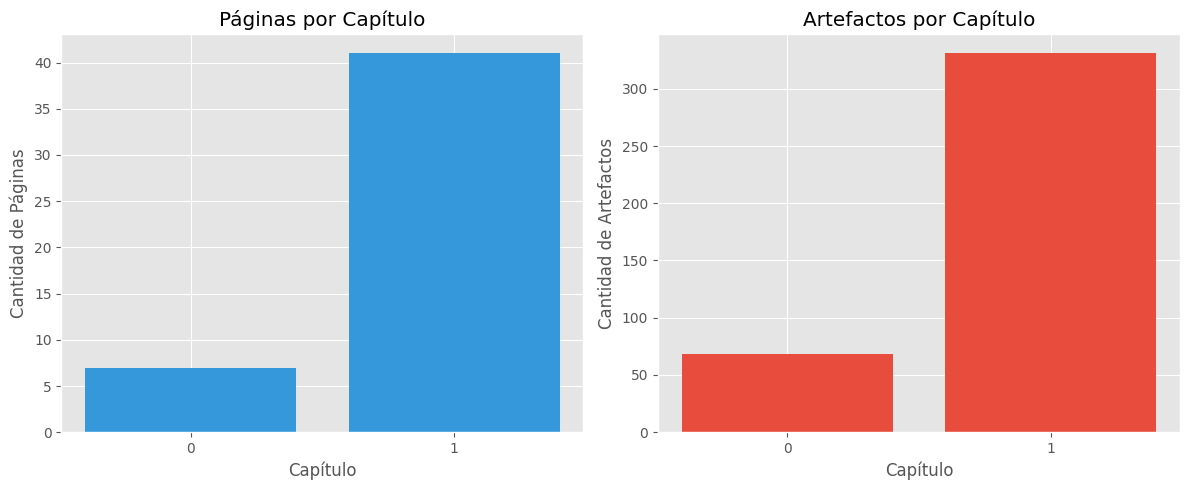

In [5]:
# Gráfico: Páginas por Capítulo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(total_pages_per_chapter['chapter'].astype(str), total_pages_per_chapter['pages'], color='#3498db')
plt.title('Páginas por Capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Cantidad de Páginas')

# Gráfico: Artefactos por Capítulo
plt.subplot(1, 2, 2)
plt.bar(total_artifacts_per_chapter['chapter'].astype(str), total_artifacts_per_chapter['artifacts'], color='#e74c3c')
plt.title('Artefactos por Capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Cantidad de Artefactos')

plt.tight_layout()
plt.show()

## 3. Comportamiento y Progreso del Usuario
Evaluamos qué tan lejos llegan los usuarios. ¿Completan todos los capítulos o abandonan al principio?

In [6]:
# Capítulos y Páginas por Usuario
chapters_per_user = droped_df.groupby('_idUser')['chapter'].nunique().reset_index(name='chapters')
pages_per_user = droped_df.groupby('_idUser')['page'].nunique().reset_index(name='pages')

# Promedios
avg_chapters = chapters_per_user['chapters'].mean()
avg_pages = pages_per_user['pages'].mean()

print(f"Promedio de capítulos visitados por usuario: {avg_chapters:.2f}")
print(f"Promedio de páginas visitadas por usuario: {avg_pages:.2f}")

Promedio de capítulos visitados por usuario: 1.80
Promedio de páginas visitadas por usuario: 32.66


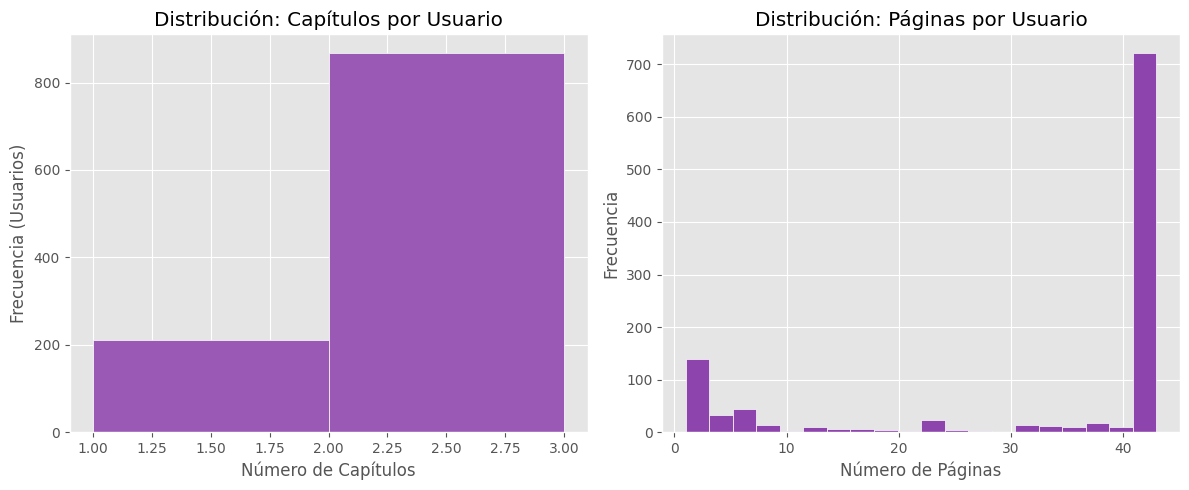

In [7]:
# Histogramas de Progreso
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(chapters_per_user['chapters'], bins=range(1, int(chapters_per_user['chapters'].max()) + 2), 
         edgecolor='white', color='#9b59b6')
plt.title('Distribución: Capítulos por Usuario')
plt.xlabel('Número de Capítulos')
plt.ylabel('Frecuencia (Usuarios)')

plt.subplot(1, 2, 2)
plt.hist(pages_per_user['pages'], bins=20, edgecolor='white', color='#8e44ad')
plt.title('Distribución: Páginas por Usuario')
plt.xlabel('Número de Páginas')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 4. Interacción y Reintentos
Analizamos la cantidad de ejercicios completados y los reintentos (artefactos repetidos), lo cual puede ser un indicador de la dificultad del contenido o del compromiso del usuario.

In [8]:
# Ejercicios completos
ejercicios_completos = droped_df[droped_df['validationArtifact'] == True].groupby('_idUser').size().reset_index(name='completed')

# Reintentos (Artefactos repetidos)
artifact_counts = droped_df.groupby(['_idUser', 'artifact']).size().reset_index(name='count')
reintentos = artifact_counts[artifact_counts['count'] > 1].copy()
reintentos['reintentos_count'] = reintentos['count'] - 1
total_reintentos = reintentos.groupby('_idUser')['reintentos_count'].sum().reset_index(name='total_reintentos')

print(f"Promedio de ejercicios completados: {ejercicios_completos['completed'].mean():.2f}")
print(f"Promedio de reintentos por usuario: {total_reintentos['total_reintentos'].mean():.2f}")

Promedio de ejercicios completados: 376.02
Promedio de reintentos por usuario: 1078.07


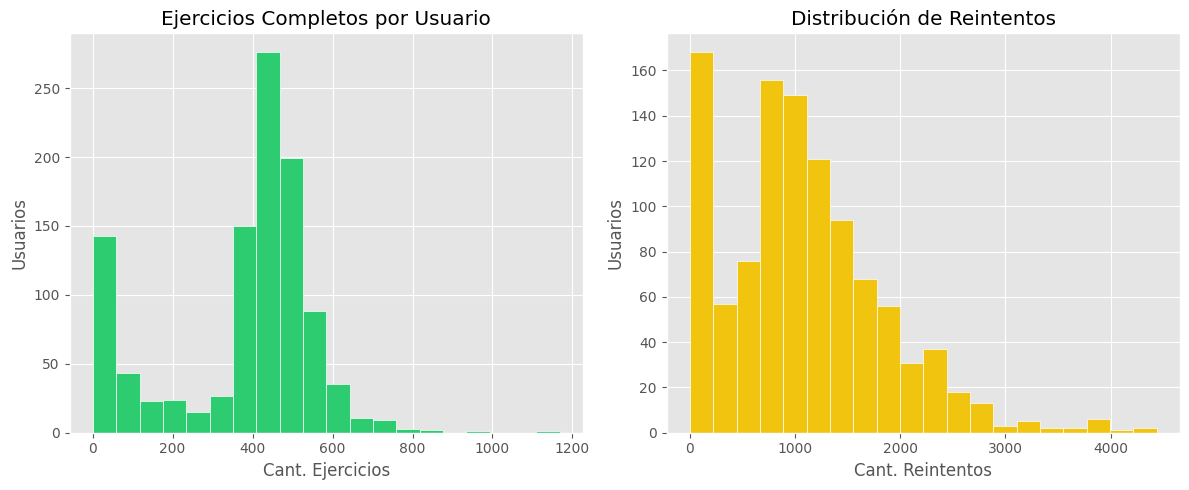

In [9]:
plt.figure(figsize=(12, 5))

# Ejercicios Completos
plt.subplot(1, 2, 1)
plt.hist(ejercicios_completos['completed'], bins=20, edgecolor='white', color='#2ecc71')
plt.title('Ejercicios Completos por Usuario')
plt.xlabel('Cant. Ejercicios')
plt.ylabel('Usuarios')

# Reintentos
plt.subplot(1, 2, 2)
plt.hist(total_reintentos['total_reintentos'], bins=20, edgecolor='white', color='#f1c40f')
plt.title('Distribución de Reintentos')
plt.xlabel('Cant. Reintentos')
plt.ylabel('Usuarios')

plt.tight_layout()
plt.show()

## 5. Tiempo por unidad

Al analizar las horas totales consumidas por unidad, se puede determinar el "peso" real de cada sección dentro del curso. Este indicador es vital para detectar cuellos de botella: las páginas o capítulos con picos de horas consumidas sugieren puntos donde los estudiantes se detienen más, ya sea por complejidad pedagógica o porque el contenido es altamente relevante para ellos.

In [10]:
# Cálculos de segundos
total_seconds_per_chapter = droped_df.groupby('chapter')['seconds'].sum().reset_index(name='total_seconds')
total_seconds_per_page = droped_df.groupby('page')['seconds'].sum().reset_index(name='total_seconds')

print("Horas consumidas por capítulo:\n", total_seconds_per_chapter.assign(total_hours=total_seconds_per_chapter['total_seconds'] / 3600))
print("Horas consumidas por página:\n", total_seconds_per_page.assign(total_hours=total_seconds_per_page['total_seconds'] / 3600))

Horas consumidas por capítulo:
    chapter  total_seconds   total_hours
0        0       19280073   5355.575833
1        1       37909541  10530.428056
Horas consumidas por página:
     page  total_seconds  total_hours
0    1.0        2210761   614.100278
1    1.1        3298853   916.348056
2    2.0        4260252  1183.403333
3    2.1        3050365   847.323611
4    3.0        3177939   882.760833
5    3.1          77342    21.483889
6    4.0        1611702   447.695000
7    5.0        3709239  1030.344167
8    6.0        5168030  1435.563889
9    7.0         261738    72.705000
10   8.0        1311647   364.346389
11   9.0         394885   109.690278
12  10.0        1145487   318.190833
13  10.1         638670   177.408333
14  11.0         866275   240.631944
15  12.0        1176706   326.862778
16  13.0        1423052   395.292222
17  14.0         824690   229.080556
18  14.1         617263   171.461944
19  15.0         632389   175.663611
20  16.0         578638   160.732778
21  

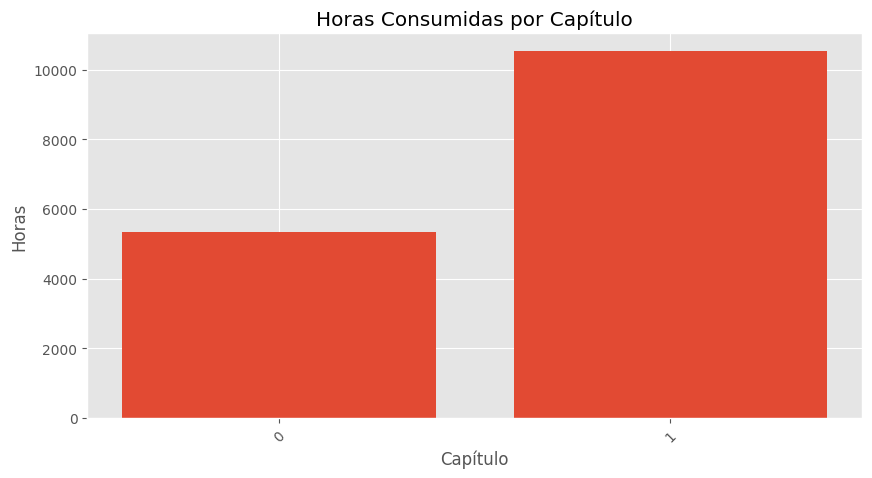

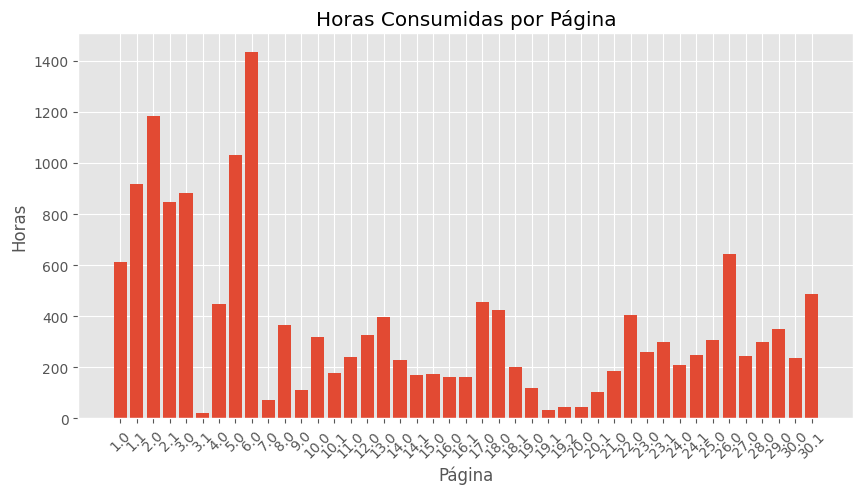

In [11]:
# Gráfico de horas consumidas por capítulo
plt.figure(figsize=(10, 5))
plt.bar(total_seconds_per_chapter['chapter'].astype(str), total_seconds_per_chapter['total_seconds'] / 3600)
plt.title('Horas Consumidas por Capítulo')
plt.xlabel('Capítulo')
plt.ylabel('Horas')
plt.xticks(rotation=45)
plt.show()

# Gráfico de horas consumidas por página
plt.figure(figsize=(10, 5))
plt.bar(total_seconds_per_page['page'].astype(str), total_seconds_per_page['total_seconds'] / 3600)
plt.title('Horas Consumidas por Página')
plt.xlabel('Página')
plt.ylabel('Horas')
plt.xticks(rotation=45)
plt.show()


# Comportamiento del tiempo


In [12]:
media = droped_df["seconds"].mean()
variacion = droped_df["seconds"].std()


limite = media +  2 * variacion 
print("La media es de: ", media)
print("La variacion estandar: ", variacion)

droped_df = droped_df[droped_df['seconds'] <= limite].copy()
# df_filtered.to_csv('output.csv', index=False)


La media es de:  49.21035222768912
La variacion estandar:  193.1673580281536


El uso de la media (μ) y la desviación estándar (σ) es un método estadístico fundamental y ampliamente adoptado para la detección y gestión de valores atípicos (outliers) en un conjunto de datos. Al filtrar las entradas que se pasen de dos veces la variacion estandar más la media podemos descartar las anomalias que se encuentran en el 5% de la distribucion.

# Comportamiento por artefacto


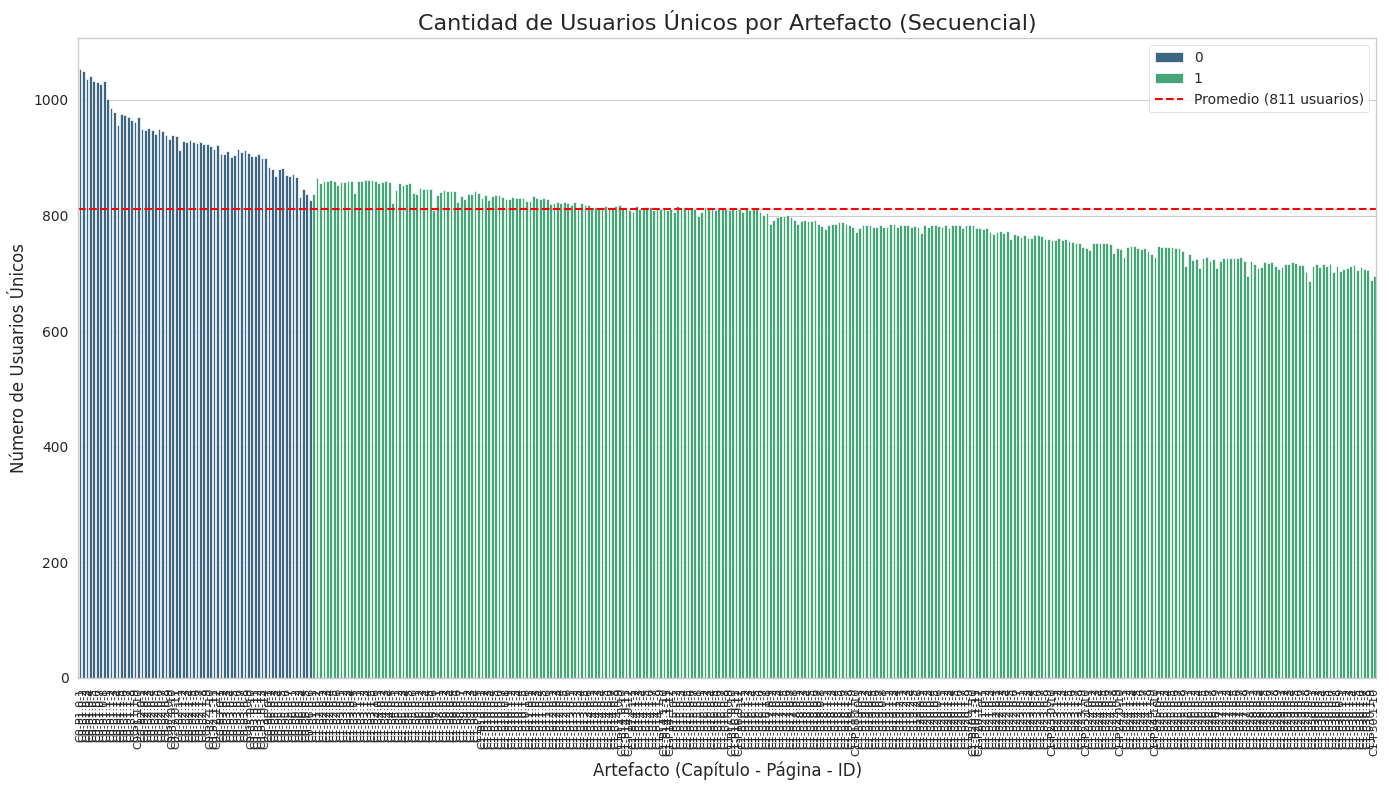

In [13]:

# 1. Preparación de los datos
# Agrupamos por capítulo, página y artefacto, contando usuarios únicos
interaction_counts = droped_df.groupby(['chapter', 'page', 'artifact'])['_idUser'].nunique().reset_index()
interaction_counts.rename(columns={'_idUser': 'unique_users'}, inplace=True)

# Creamos una etiqueta compuesta para el eje X (Ej: C1-P1.1-ArtA)
# Esto ayuda a que la gráfica sea legible si hay muchos artefactos
interaction_counts['label'] = (
    "C" + interaction_counts['chapter'].astype(str) + 
    "-P" + interaction_counts['page'].astype(str) + 
    "-" + interaction_counts['artifact'].astype(str)
)

# Ordenamos para mantener la secuencia lógica del curso
interaction_counts.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Crear el gráfico de barras
barplot = sns.barplot(
    data=interaction_counts,
    x='label',
    y='unique_users',
    hue='chapter',  # Colorear por capítulo para distinguir secciones visualmente
    dodge=False,    # Las barras se mantienen alineadas
    palette='viridis'
)

# 3. Personalización
plt.title('Cantidad de Usuarios Únicos por Artefacto (Secuencial)', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Número de Usuarios Únicos', fontsize=12)

# Rotar las etiquetas del eje X para que no se superpongan
plt.xticks(rotation=90, fontsize=8)

# Añadir una línea de promedio para referencia
avg_users = interaction_counts['unique_users'].mean()
plt.axhline(avg_users, color='red', linestyle='--', label=f'Promedio ({int(avg_users)} usuarios)')
plt.legend()

plt.tight_layout()
plt.show()

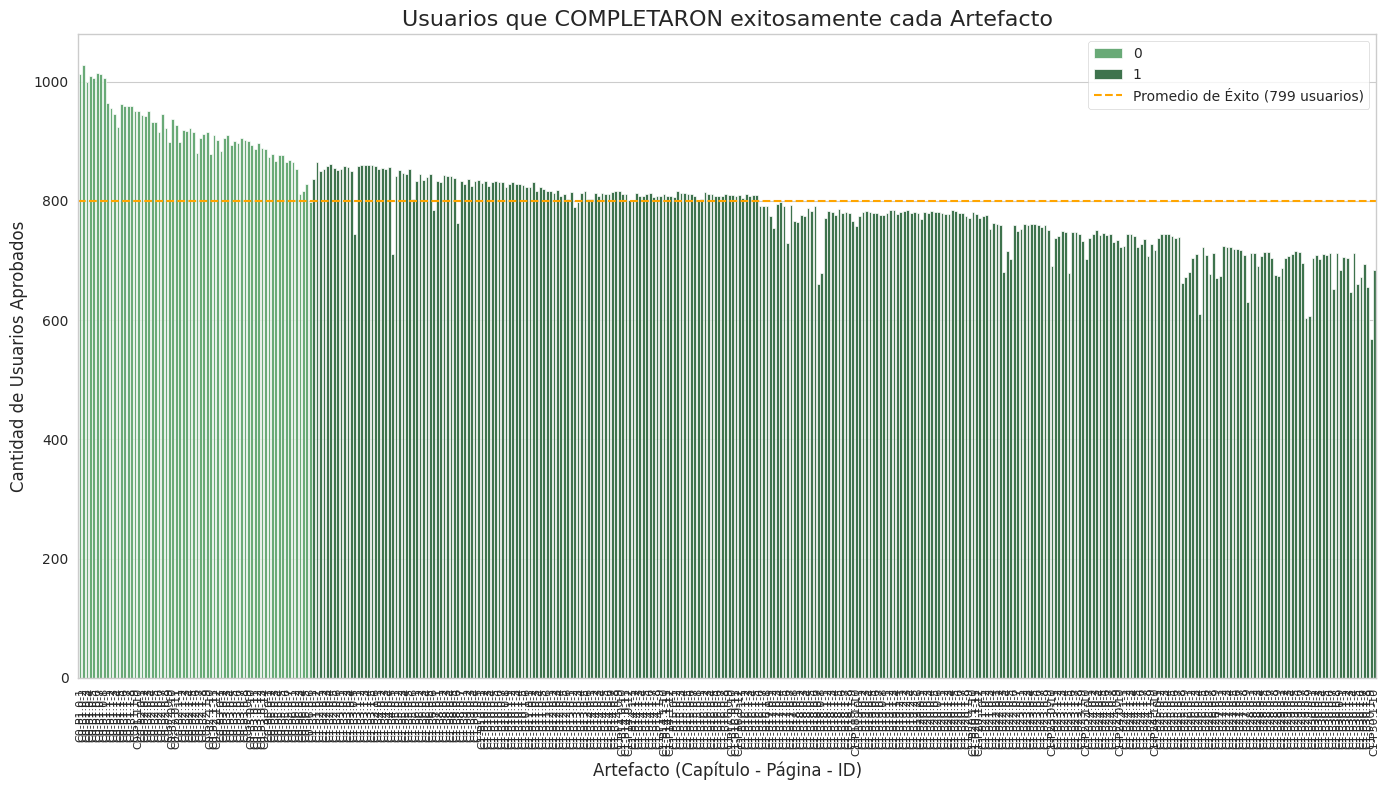

In [14]:

# 1. Filtrado y Preparación
# Filtramos solo donde validationArtifact es True (el usuario resolvió el ejercicio)
completed_data = droped_df[droped_df['validationArtifact'] == True]

# Agrupamos por jerarquía
success_counts = completed_data.groupby(['chapter', 'page', 'artifact'])['_idUser'].nunique().reset_index()
success_counts.rename(columns={'_idUser': 'successful_users'}, inplace=True)

# Crear etiqueta legible (C#-P#-Art#)
success_counts['label'] = (
    "C" + success_counts['chapter'].astype(str) + 
    "-P" + success_counts['page'].astype(str) + 
    "-" + success_counts['artifact'].astype(str)
)

# Ordenar secuencialmente
success_counts.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Usamos una paleta de verdes para denotar "éxito"
success_plot = sns.barplot(
    data=success_counts,
    x='label',
    y='successful_users',
    hue='chapter',
    dodge=False,
    palette='Greens_d' # Paleta verde oscura
)

# 3. Personalización
plt.title('Usuarios que COMPLETARON exitosamente cada Artefacto', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Cantidad de Usuarios Aprobados', fontsize=12)
plt.xticks(rotation=90, fontsize=8)

# Línea de promedio de aprobados
avg_success = success_counts['successful_users'].mean()
plt.axhline(avg_success, color='orange', linestyle='--', label=f'Promedio de Éxito ({int(avg_success)} usuarios)')
plt.legend()

plt.tight_layout()
plt.show()

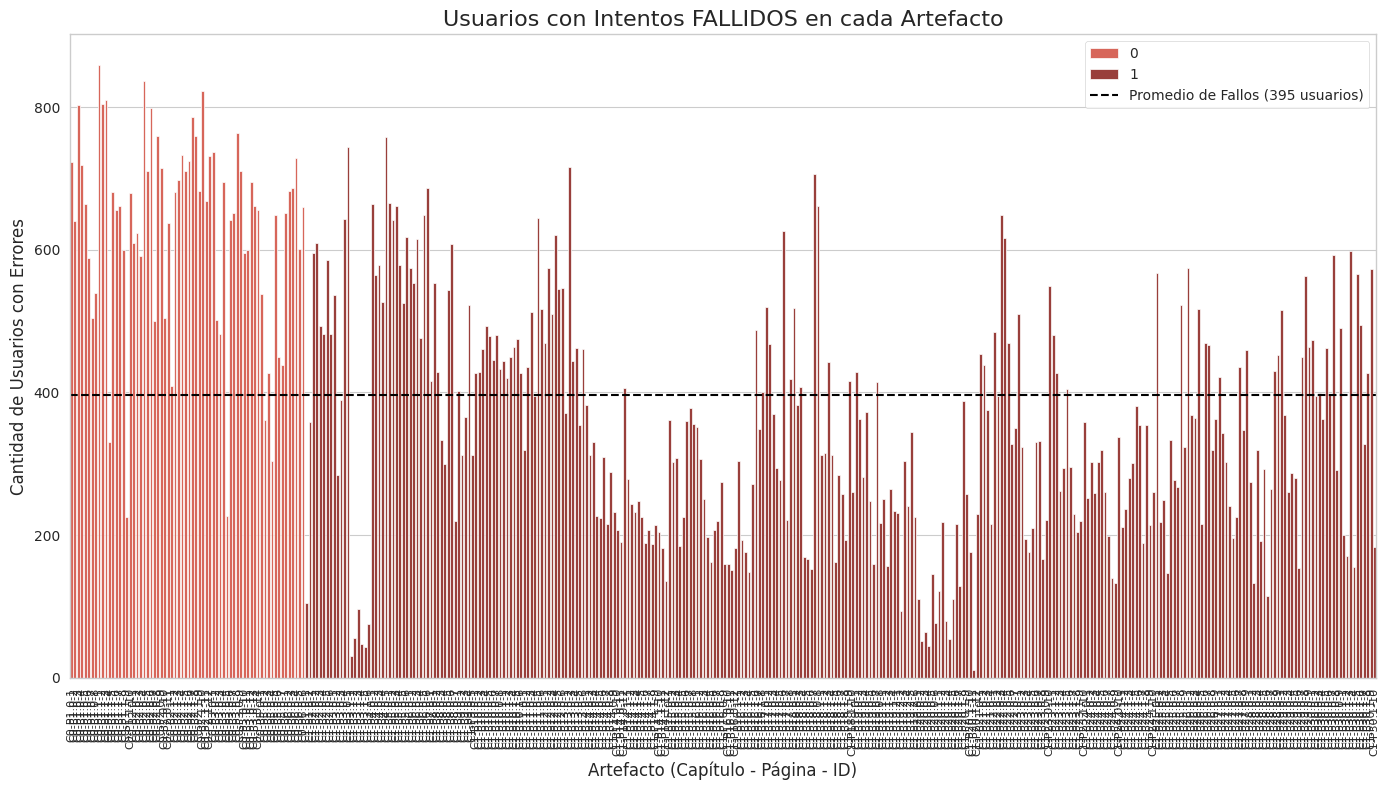

In [15]:

# 1. Filtrado y Preparación
# Filtramos donde validationArtifact es False (error o incompleto)
failed_data = droped_df[droped_df['validationArtifact'] == False]

# Agrupamos por jerarquía
fail_counts = failed_data.groupby(['chapter', 'page', 'artifact'])['_idUser'].nunique().reset_index()
fail_counts.rename(columns={'_idUser': 'failed_users'}, inplace=True)

# Crear etiqueta legible
fail_counts['label'] = (
    "C" + fail_counts['chapter'].astype(str) + 
    "-P" + fail_counts['page'].astype(str) + 
    "-" + fail_counts['artifact'].astype(str)
)

# Ordenar secuencialmente
fail_counts.sort_values(by=['chapter', 'page', 'artifact'], inplace=True)

# 2. Configuración de la Gráfica
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Usamos una paleta de Rojos para denotar "error/alerta"
fail_plot = sns.barplot(
    data=fail_counts,
    x='label',
    y='failed_users',
    hue='chapter',
    dodge=False,
    palette='Reds_d' # Paleta de rojos oscuros
)

# 3. Personalización
plt.title('Usuarios con Intentos FALLIDOS en cada Artefacto', fontsize=16)
plt.xlabel('Artefacto (Capítulo - Página - ID)', fontsize=12)
plt.ylabel('Cantidad de Usuarios con Errores', fontsize=12)
plt.xticks(rotation=90, fontsize=8)

# Línea de promedio de fallos (para detectar los casos críticos)
avg_fail = fail_counts['failed_users'].mean()
plt.axhline(avg_fail, color='black', linestyle='--', label=f'Promedio de Fallos ({int(avg_fail)} usuarios)')
plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_16194/2990445065.py:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  droped_df['date'] = pd.to_datetime(droped_df['date'])


            day  num_artifacts
0    2024-10-25             84
1    2024-10-26            116
2    2024-10-27           1393
3    2024-10-28          16380
4    2024-10-29          41244
..          ...            ...
111  2025-03-14             61
112  2025-03-15              1
113  2025-03-16            260
114  2025-03-17             43
115  2025-03-18             26

[116 rows x 2 columns]


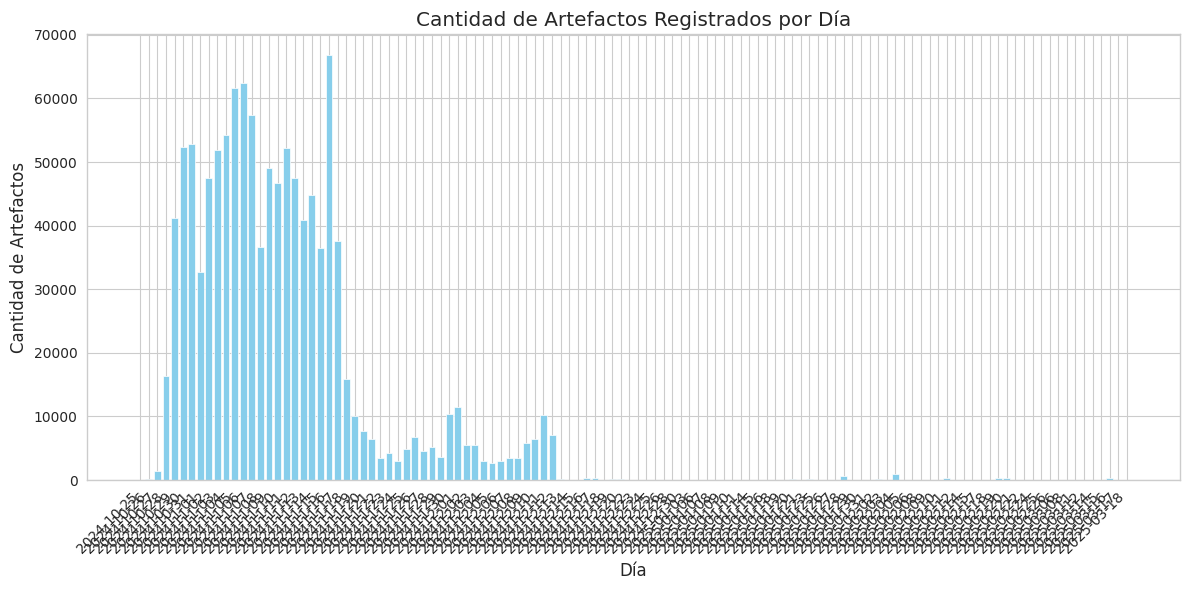

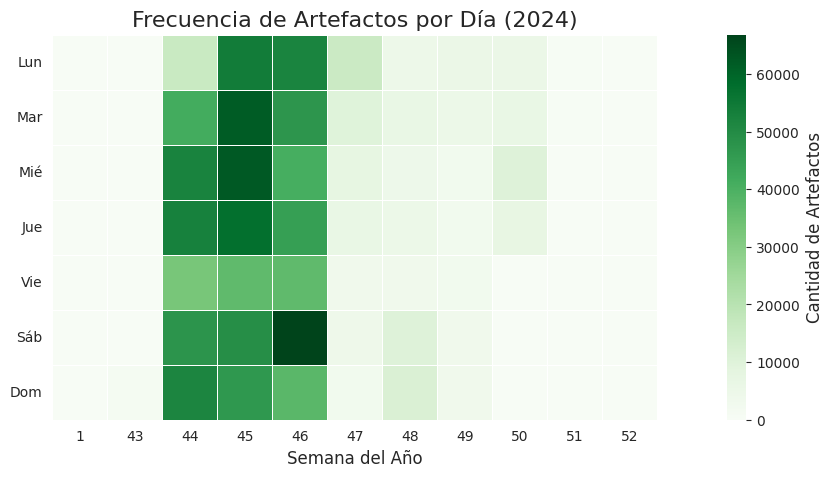

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Suponiendo que el DataFrame se llama 'df' y tiene las columnas 'date' y 'artifact'
# --- PASO 1: Asegurarse de que la columna 'date' sea datetime y extraer la fecha
droped_df['date'] = pd.to_datetime(droped_df['date'])
droped_df['day'] = droped_df['date'].dt.date

# --- PASO 2: Contar los artefactos por día
artifacts_per_day = droped_df.groupby('day')['artifact'].count().reset_index()
artifacts_per_day.rename(columns={'artifact': 'num_artifacts'}, inplace=True)

# --- PASO 3: Mostrar el resultado
print(artifacts_per_day)

# Para un gráfico de barras simple (que es más fácil que un "calendar plot" sin bibliotecas especializadas)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(artifacts_per_day['day'].astype(str), artifacts_per_day['num_artifacts'], color='skyblue')
plt.title('Cantidad de Artefactos Registrados por Día')
plt.xlabel('Día')
plt.ylabel('Cantidad de Artefactos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


    # 1. Conversión de la columna 'date' a formato datetime
droped_df['date'] = pd.to_datetime(droped_df['date'])

    # 2. Agregación: Contar artefactos por día
artifacts_per_day = droped_df.groupby(droped_df['date'].dt.date)['artifact'].count()
artifacts_per_day.index = pd.to_datetime(artifacts_per_day.index)
    
    # 3. Preparación para el Heatmap Calendar
calendar_df = pd.DataFrame(artifacts_per_day)
calendar_df.columns = ['Count']
    
    # Extraer características temporales
calendar_df['DayOfWeek'] = calendar_df.index.dayofweek # Lunes=0, Domingo=6
calendar_df['WeekOfYear'] = calendar_df.index.isocalendar().week.astype(int)
calendar_df['Year'] = calendar_df.index.year
    
    # Seleccionar el año (si hay varios)
year_to_plot = calendar_df['Year'].min()
df_year = calendar_df[calendar_df['Year'] == year_to_plot]

    # Pivotear la tabla: Filas = Día de la Semana, Columnas = Semana del Año
pivot_table = df_year.pivot_table(
    values='Count', 
    index='DayOfWeek', 
    columns='WeekOfYear', 
    fill_value=0
)
    
    # 4. Generación del Heatmap
day_labels = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
pivot_table.index = day_labels

plt.figure(figsize=(18, 5))
    
sns.heatmap(
    pivot_table,
    cmap="Greens", # Color similar a GitHub
    linewidths=0.5,
    linecolor='white',
    square=True,
    cbar_kws={'label': 'Cantidad de Artefactos'},
    yticklabels=day_labels,
    vmax=pivot_table.values.max() 
)
    
plt.title(f'Frecuencia de Artefactos por Día ({year_to_plot})', fontsize=16)
plt.xlabel('Semana del Año')
plt.ylabel('')
plt.yticks(rotation=0)
    
plt.savefig('calendar_heatmap.png')
plt.show()

In [17]:
import pandas as pd

# 1. Filtrar solo los intentos fallidos
only_failures = droped_df[droped_df['validationArtifact'] == False]

# 2. Contar cuántas veces falló cada usuario en cada artefacto específico
user_fail_counts = only_failures.groupby(['chapter', 'page', 'artifact', '_idUser']).size().reset_index(name='fail_count')

# 3. Calcular "Reintentos Fallidos" (Cualquier fallo después del primero)
# Si falló 3 veces: 1er intento (error) + 2 reintentos (errores) -> Valor = 2
user_fail_counts['failed_retries'] = user_fail_counts['fail_count'] - 1

# Filtrar para dejar solo aquellos donde hubo persistencia en el error
blocking_events = user_fail_counts[user_fail_counts['failed_retries'] > 0]

# 4. Agrupar por artefacto para obtener el puntaje total de bloqueo
top_blocking = blocking_events.groupby(['chapter', 'page', 'artifact'])['failed_retries'].sum().reset_index()

# Crear etiqueta legible
top_blocking['Artefacto_ID'] = (
    "C" + top_blocking['chapter'].astype(str) + 
    "-P" + top_blocking['page'].astype(str) + 
    "-" + top_blocking['artifact'].astype(str)
)

# 5. Ordenar de mayor a menor bloqueo y tomar los top 25
top_25_blocking = top_blocking.sort_values(by='failed_retries', ascending=False).head(25)

# Limpiar la tabla para mostrar
final_list = top_25_blocking[['Artefacto_ID', 'failed_retries']].reset_index(drop=True)
final_list.columns = ['Identificador (C-P-A)', 'Total Reintentos Fallidos']

# Mostrar la lista
print("=== TOP 25 ARTEFACTOS BLOQUEANTES ===")
print(final_list)

# Opcional: Si quieres exportarlo a CSV para revisarlo luego
# final_list.to_csv('top_25_bloqueantes.csv', index=False)

=== TOP 25 ARTEFACTOS BLOQUEANTES ===
   Identificador (C-P-A)  Total Reintentos Fallidos
0             C1-P13.0-2                      10587
1              C0-P6.0-4                       8995
2             C1-P18.0-7                       8135
3              C1-P8.0-6                       7691
4              C0-P6.0-2                       7558
5             C1-P17.0-6                       7158
6             C1-P30.1-3                       6875
7             C1-P12.0-4                       6713
8             C0-P2.1-10                       6701
9              C0-P1.1-1                       6165
10            C1-P25.0-8                       6097
11             C0-P6.0-3                       5972
12             C1-P2.0-2                       5926
13             C0-P6.0-6                       5884
14            C1-P18.0-8                       5601
15            C1-P17.0-1                       5535
16            C1-P26.0-1                       5433
17            C1-P29.0-8  

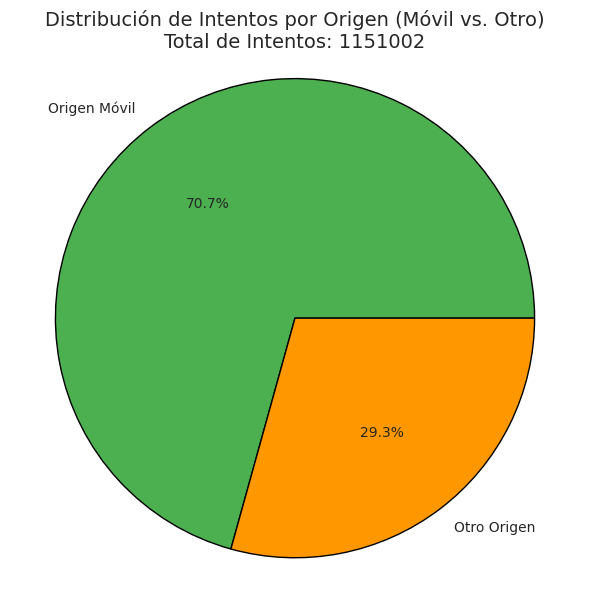

----------------------------------------
Número Total de Intentos (Registros): 1151002
Distribución Detallada:
- Origen Móvil: 813640 (70.7%)
- Otro Origen: 337362 (29.3%)
----------------------------------------


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Conteo de registros para cada valor de la columna 'originMovil'
conteo_origen = droped_df['originMovil'].value_counts()

# Número total de intentos 
total_intentos = droped_df.shape[0]

# Etiquetas y colores
labels_raw = conteo_origen.index.tolist()
labels_map = {True: 'Origen Móvil', False: 'Otro Origen'}
labels = [labels_map[val] for val in labels_raw]

colors = ['#4CAF50', '#FF9800'] 

# 3. VISUALIZACIÓN
plt.figure(figsize=(6, 6))

plt.pie(
    conteo_origen.values,
    labels=labels,
    colors=colors[:len(labels)],
    # Muestra el porcentaje en cada porción con 1 decimal
    autopct='%1.1f%%', 
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True},
)

# Número total de intentos
plt.title(f'Distribución de Intentos por Origen (Móvil vs. Otro)\nTotal de Intentos: {total_intentos}', fontsize=14)
plt.axis('equal') 

plt.tight_layout()
plt.show()

# Resultados
print("-" * 40)
print(f"Número Total de Intentos (Registros): {total_intentos}")
print(f"Distribución Detallada:")
for i, count in enumerate(conteo_origen):
    print(f"- {labels[i]}: {count} ({conteo_origen.iloc[i] / total_intentos:.1%})")
print("-" * 40)

In [20]:
import pandas as pd
import numpy as np 

droped_df['minutes'] = droped_df['seconds'] / 60

droped_df['label'] = (
        "C" + droped_df['chapter'].astype(str) +
        "-P" + droped_df['page'].astype(str) +
        "-" + droped_df['artifact'].astype(str)
)

# 1. PREPARACIÓN NIVEL USUARIO
user_interactions = droped_df.groupby(['_idUser', 'label', 'chapter']).agg(
    visits=('label', 'count'),          # Cuántas veces entró
    avg_minutes=('minutes', 'mean')     # Tiempo promedio por visita
).reset_index()

# Calculamos repeticiones reales (visitas - 1)
user_interactions['repeticiones'] = user_interactions['visits'] - 1

# 2. AGREGACIÓN NIVEL ARTEFACTO (El Indicador)
difficulty_table = user_interactions.groupby(['label', 'chapter']).agg(
    usuarios_unicos=('_idUser', 'nunique'),     # Cuánta gente pasó por aquí
    total_repeticiones=('repeticiones', 'sum'), # Total bruto de reintentos
    tiempo_promedio=('avg_minutes', 'mean')     # Tiempo promedio global
).reset_index()

# 3. CÁLCULO DE LA TASA DE DIFICULTAD (KPI)
difficulty_table['tasa_reincidencia'] = difficulty_table['total_repeticiones'] / difficulty_table['usuarios_unicos']

# 4. ORDENAR Y LIMPIAR
top_difficulty = difficulty_table.sort_values(by='tasa_reincidencia', ascending=False).head(15)

# Redondeo
top_difficulty = top_difficulty.round(2)

# 5. VISUALIZACIÓN CON ESTILO (Heatmap)
styled_table = top_difficulty.style.background_gradient(
    subset=['tasa_reincidencia', 'tiempo_promedio'],
    cmap='Reds'
).format({
    'tasa_reincidencia': '{:.2f}',
    'tiempo_promedio': '{:.2f} min',
    'total_repeticiones': '{:.0f}',
    'usuarios_unicos': '{:.0f}'
})

# Mostrar la tabla
print("Top 15 Artefactos con mayor Tasa de Reincidencia (Dificultad):")
styled_table

Top 15 Artefactos con mayor Tasa de Reincidencia (Dificultad):


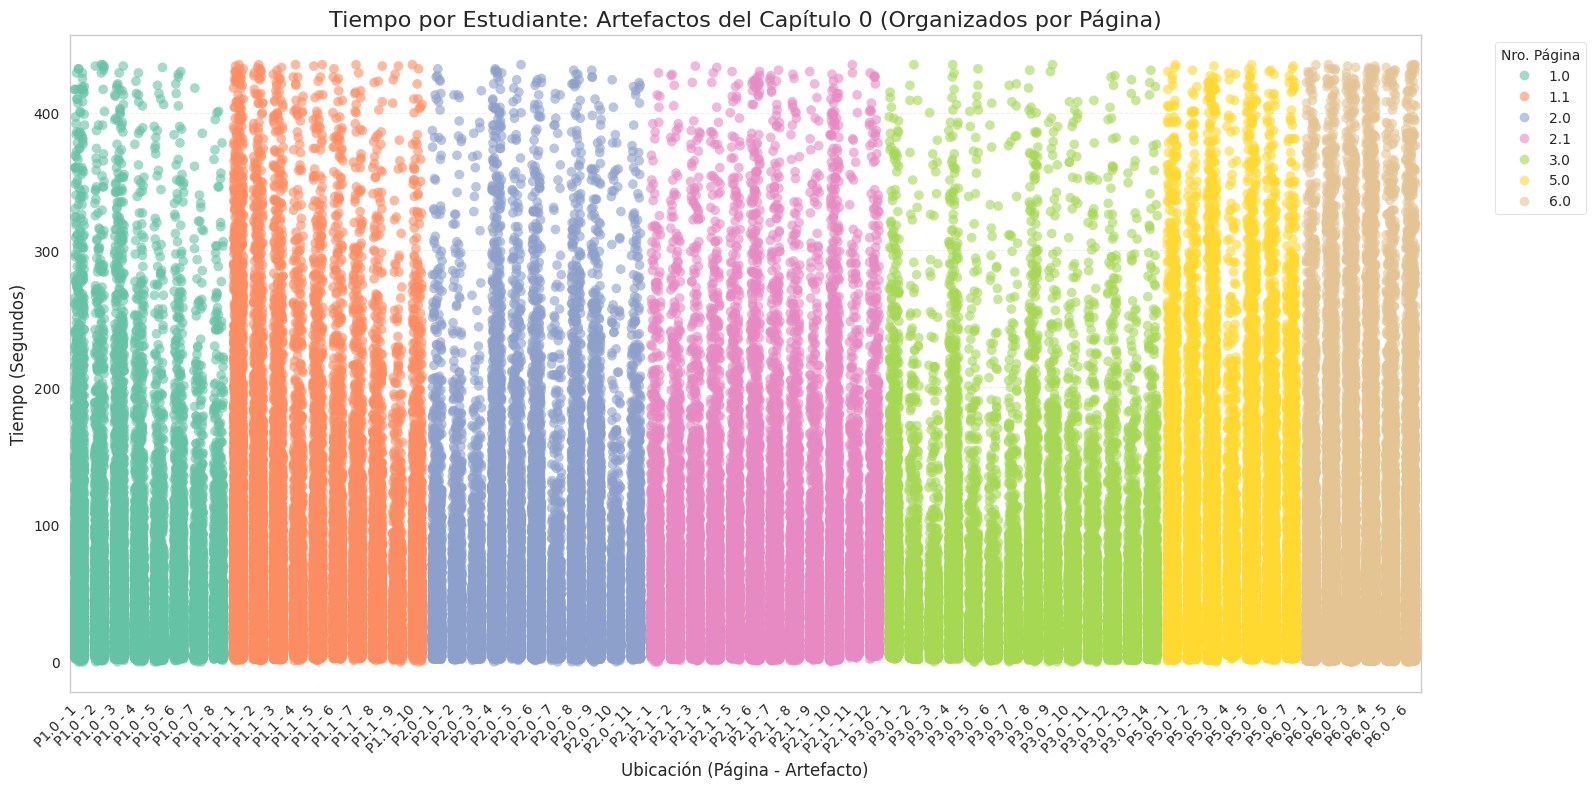

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtramos por el Capítulo 0
df_cap0 = droped_df[droped_df['chapter'] == 0].copy()

# 2. Creamos una etiqueta combinada: "Pág [X] - Art [Y]"
# Ordenamos primero por página y luego por artefacto para que la gráfica sea lógica
df_cap0 = df_cap0.sort_values(by=['page', 'artifact'])
df_cap0['page_artifact'] = "P" + df_cap0['page'].astype(str) + " - " + df_cap0['artifact'].astype(str)

# 3. Configuramos el gráfico
plt.figure(figsize=(16, 8))

# Usamos stripplot para ver a los estudiantes (puntos)
# 'hue' opcionalmente puede ser la página para darles colores distintos por sección
plot = sns.stripplot(
    data=df_cap0, 
    x='page_artifact', 
    y='seconds', 
    hue='page',       # Diferencia las páginas por colores
    jitter=0.25,      # Dispersión horizontal para ver mejor a los estudiantes
    alpha=0.6, 
    palette='Set2', 
    size=7
)

# 4. Estética y legibilidad
plt.title('Tiempo por Estudiante: Artefactos del Capítulo 0 (Organizados por Página)', fontsize=16)
plt.xlabel('Ubicación (Página - Artefacto)', fontsize=12)
plt.ylabel('Tiempo (Segundos)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotación para que no se amontonen las etiquetas
plt.legend(title='Nro. Página', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

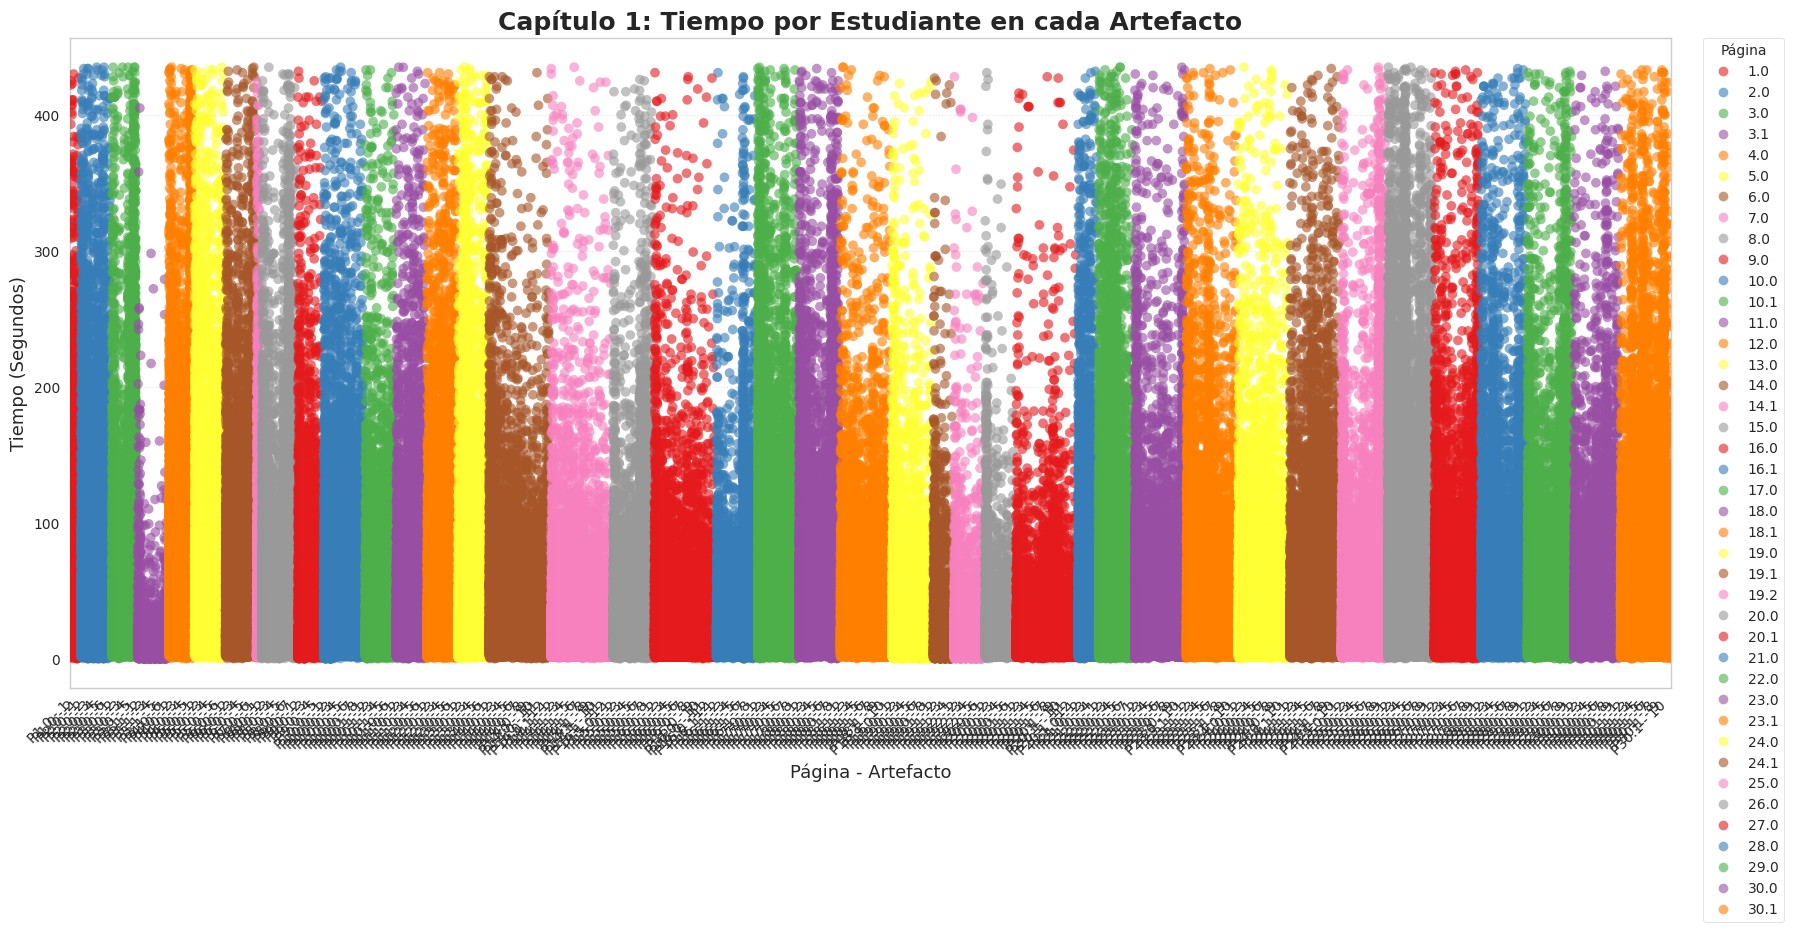

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Filtrar por el Capítulo 1
df_cap1 = droped_df[droped_df['chapter'] == 1].copy()

# 2. Ordenar por página y artefacto para mantener la secuencia lógica
df_cap1 = df_cap1.sort_values(by=['page', 'artifact'])

# 3. Crear la etiqueta combinada para el eje X
df_cap1['page_artifact'] = "P" + df_cap1['page'].astype(str) + " - " + df_cap1['artifact'].astype(str)

# 4. Configurar el estilo y tamaño de la gráfica
plt.figure(figsize=(18, 9))

# Graficar puntos individuales (estudiantes)
# He cambiado la paleta a 'Set1' para que visualmente sepas que es otro capítulo
sns.stripplot(
    data=df_cap1, 
    x='page_artifact', 
    y='seconds', 
    hue='page',       # Colores distintos por cada página
    jitter=0.3,       # Esparcimiento horizontal de los puntos
    alpha=0.6,        # Transparencia para ver dónde hay más densidad
    palette='Set1', 
    size=7
)

# 5. Personalización y etiquetas
plt.title('Capítulo 1: Tiempo por Estudiante en cada Artefacto', fontsize=18, fontweight='bold')
plt.xlabel('Página - Artefacto', fontsize=13)
plt.ylabel('Tiempo (Segundos)', fontsize=13)
plt.xticks(rotation=45, ha='right') # Rotación para evitar que los nombres se solapen

# Mover la leyenda fuera de la gráfica para que no estorbe
plt.legend(title='Página', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

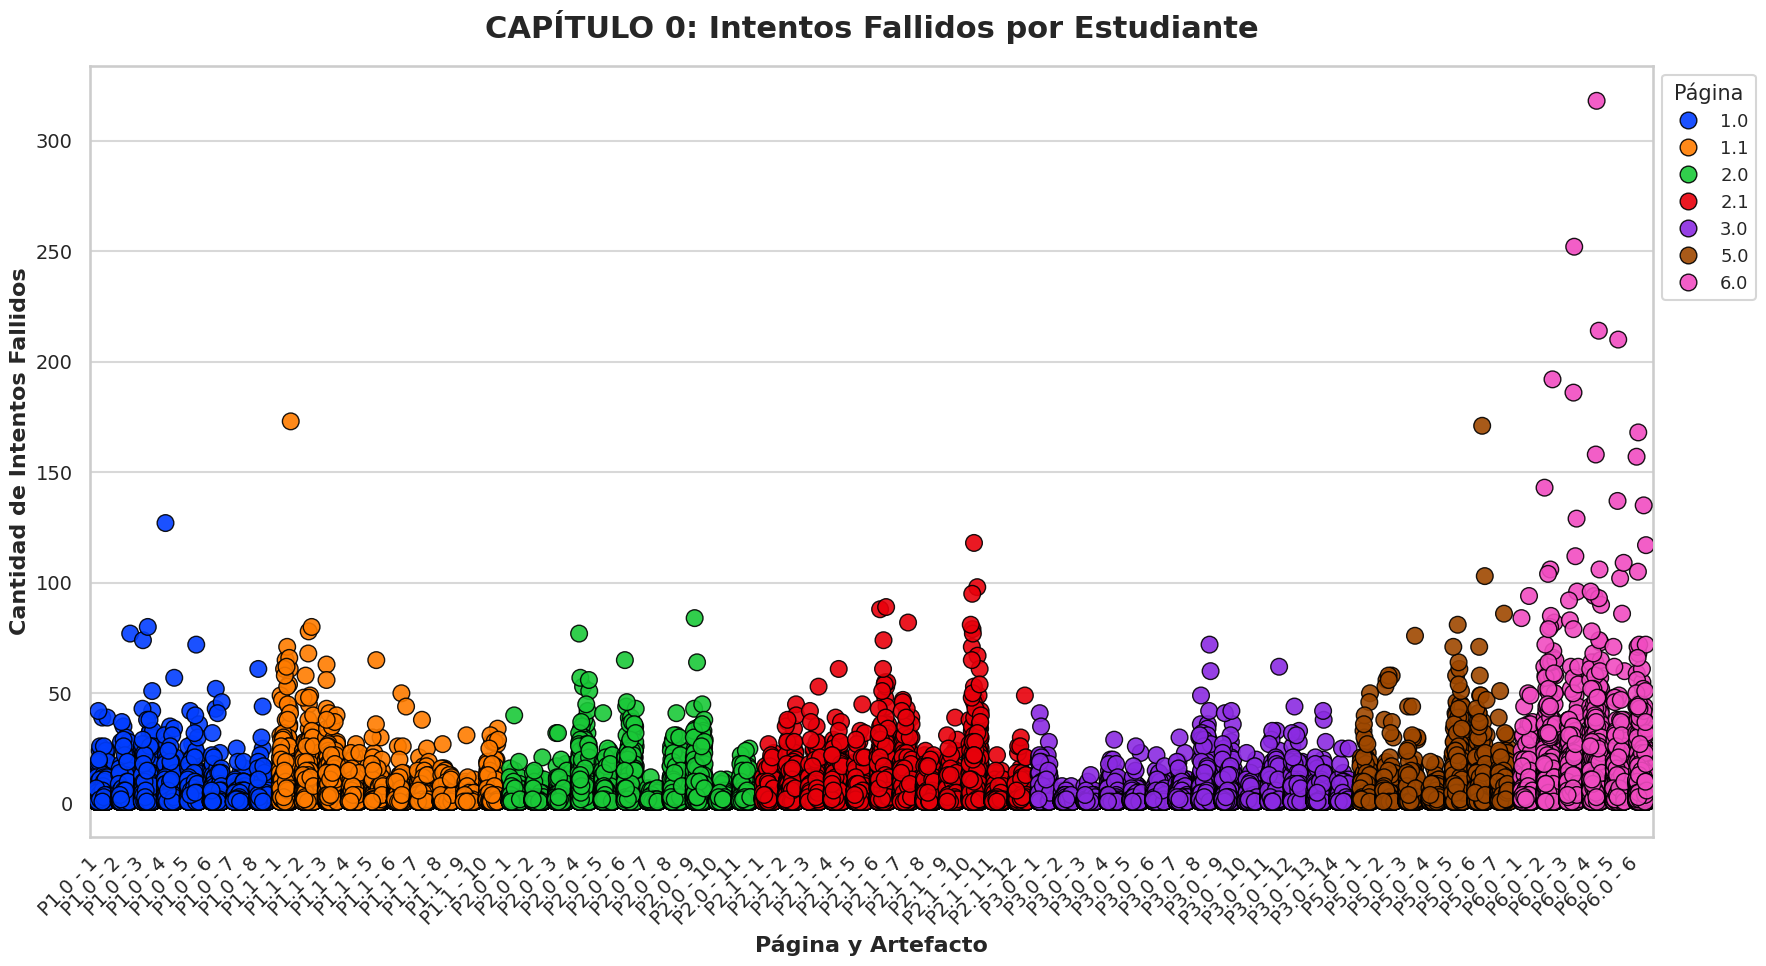

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de datos (Cap 0)
df_fails_0 = droped_df[(droped_df['chapter'] == 0) & (droped_df['validationArtifact'] == False)].copy()
df_counts_0 = df_fails_0.groupby(['_idUser', 'page', 'artifact']).size().reset_index(name='failed_attempts')
df_counts_0 = df_counts_0.sort_values(by=['page', 'artifact'])
df_counts_0['label'] = "P" + df_counts_0['page'].astype(str) + " - " + df_counts_0['artifact'].astype(str)

# 2. Configuración de accesibilidad
plt.figure(figsize=(18, 10))
sns.set_context("talk") # Aumenta el tamaño base de todos los elementos de la fuente

# 3. Gráfica con puntos grandes y definidos
sns.stripplot(
    data=df_counts_0, 
    x='label', 
    y='failed_attempts', 
    hue='page', 
    jitter=0.25, 
    alpha=0.9,           # Menos transparencia para que el color sea sólido
    palette='bright',    # Colores primarios y brillantes
    size=12,             # Puntos mucho más grandes
    edgecolor='black',   # Borde negro para contraste
    linewidth=1          # Grosor del borde
)

# 4. Etiquetas extra grandes
plt.title('CAPÍTULO 0: Intentos Fallidos por Estudiante', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Página y Artefacto', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad de Intentos Fallidos', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

plt.legend(title='Página', title_fontsize='15', fontsize='13', bbox_to_anchor=(1, 1))
plt.grid(axis='y', color='gray', linestyle='-', alpha=0.3) # Rejilla más visible

plt.tight_layout()
plt.show()

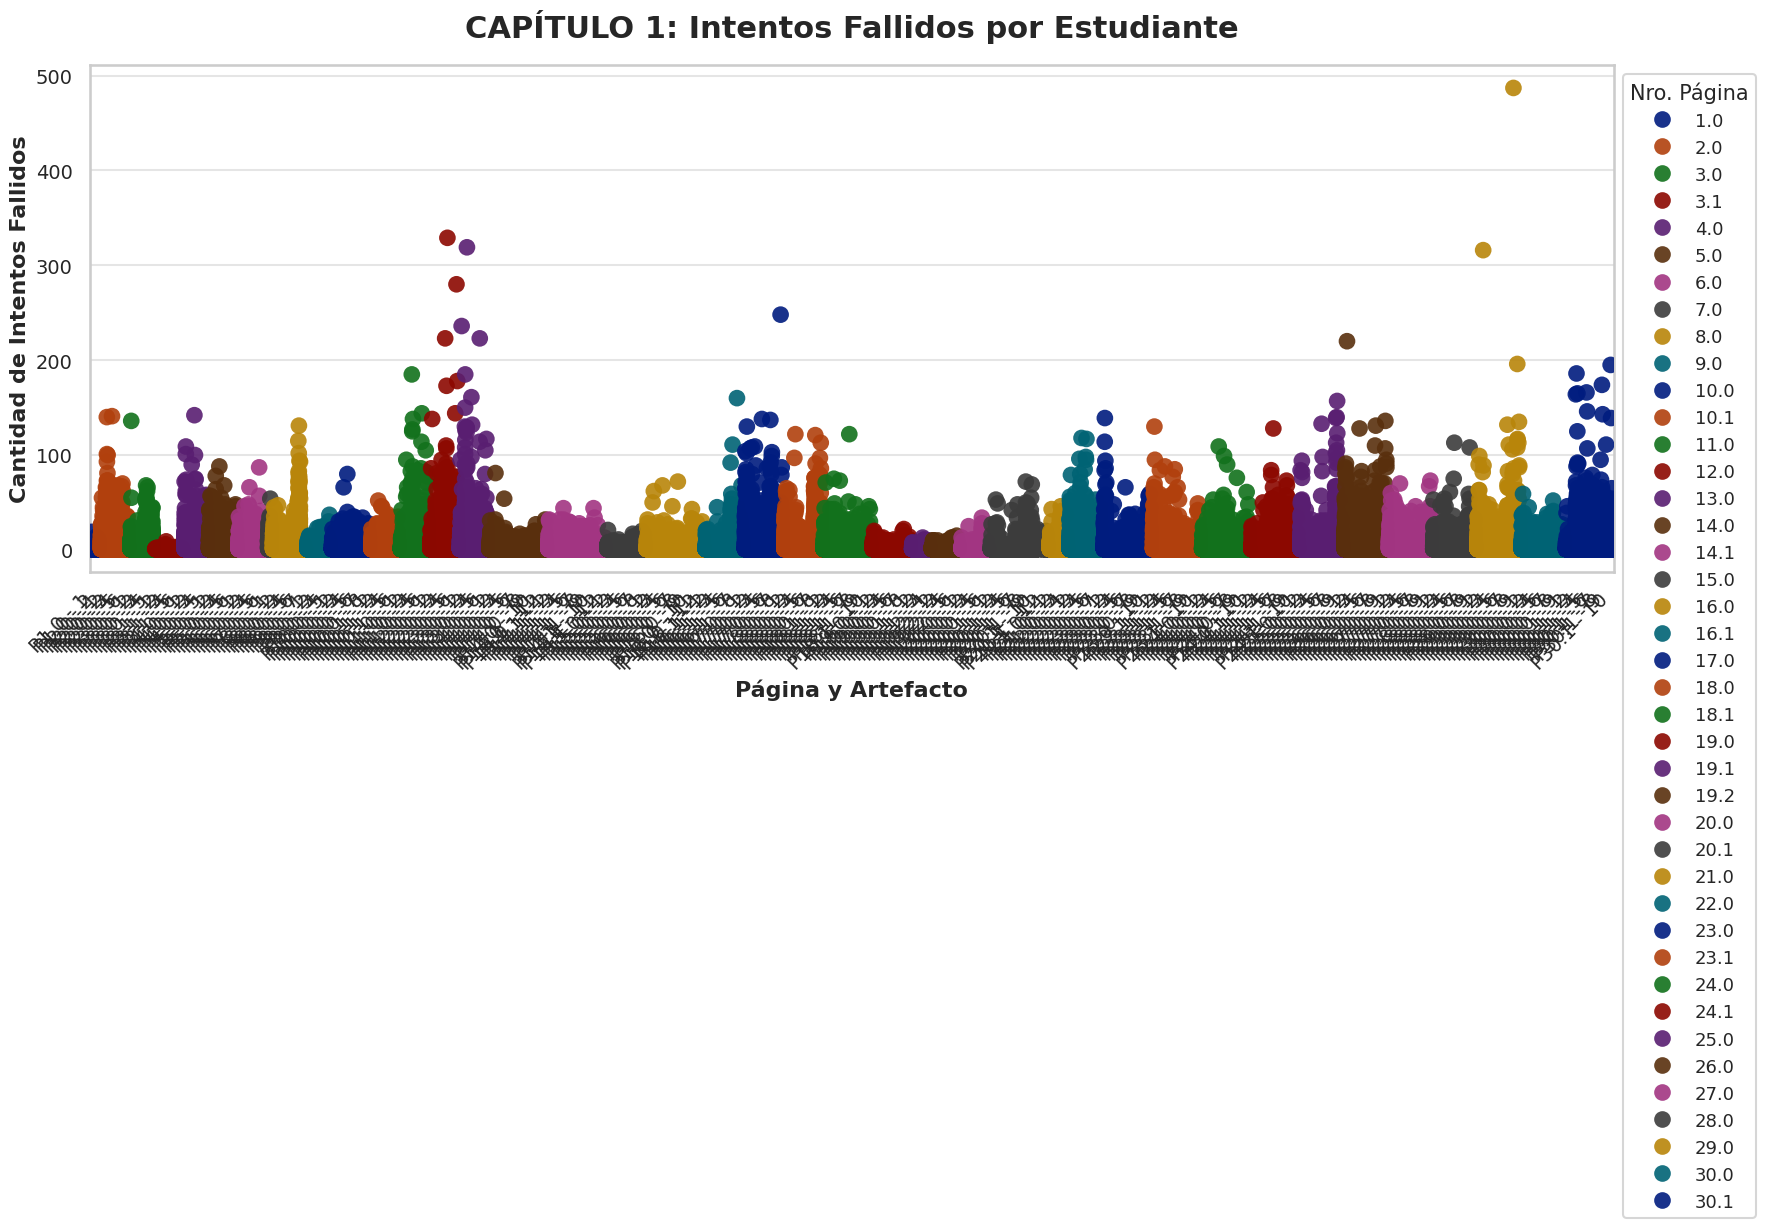

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de datos (Capítulo 1)
df_fails_1 = droped_df[(droped_df['chapter'] == 1) & (droped_df['validationArtifact'] == False)].copy()
df_counts_1 = df_fails_1.groupby(['_idUser', 'page', 'artifact']).size().reset_index(name='failed_attempts')
df_counts_1 = df_counts_1.sort_values(by=['page', 'artifact'])
df_counts_1['label'] = "P" + df_counts_1['page'].astype(str) + " - " + df_counts_1['artifact'].astype(str)

# 2. Configuración de accesibilidad (Tamaño de fuente "talk" para mejor legibilidad)
plt.figure(figsize=(18, 10))
sns.set_context("talk") 

# 3. Gráfica sin borde negro en los puntos
sns.stripplot(
    data=df_counts_1, 
    x='label', 
    y='failed_attempts', 
    hue='page', 
    jitter=0.25, 
    alpha=0.9,           
    palette='dark',      # Colores fuertes y saturados
    size=12,             # Mantenemos el tamaño grande
    linewidth=0          # <--- Aquí quitamos el borde (0 de grosor)
)

# 4. Textos grandes y claros
plt.title('CAPÍTULO 1: Intentos Fallidos por Estudiante', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Página y Artefacto', fontsize=16, fontweight='bold')
plt.ylabel('Cantidad de Intentos Fallidos', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Ajustar leyenda y rejilla para que no estorben
plt.legend(title='Nro. Página', title_fontsize='15', fontsize='13', bbox_to_anchor=(1, 1))
plt.grid(axis='y', color='gray', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()

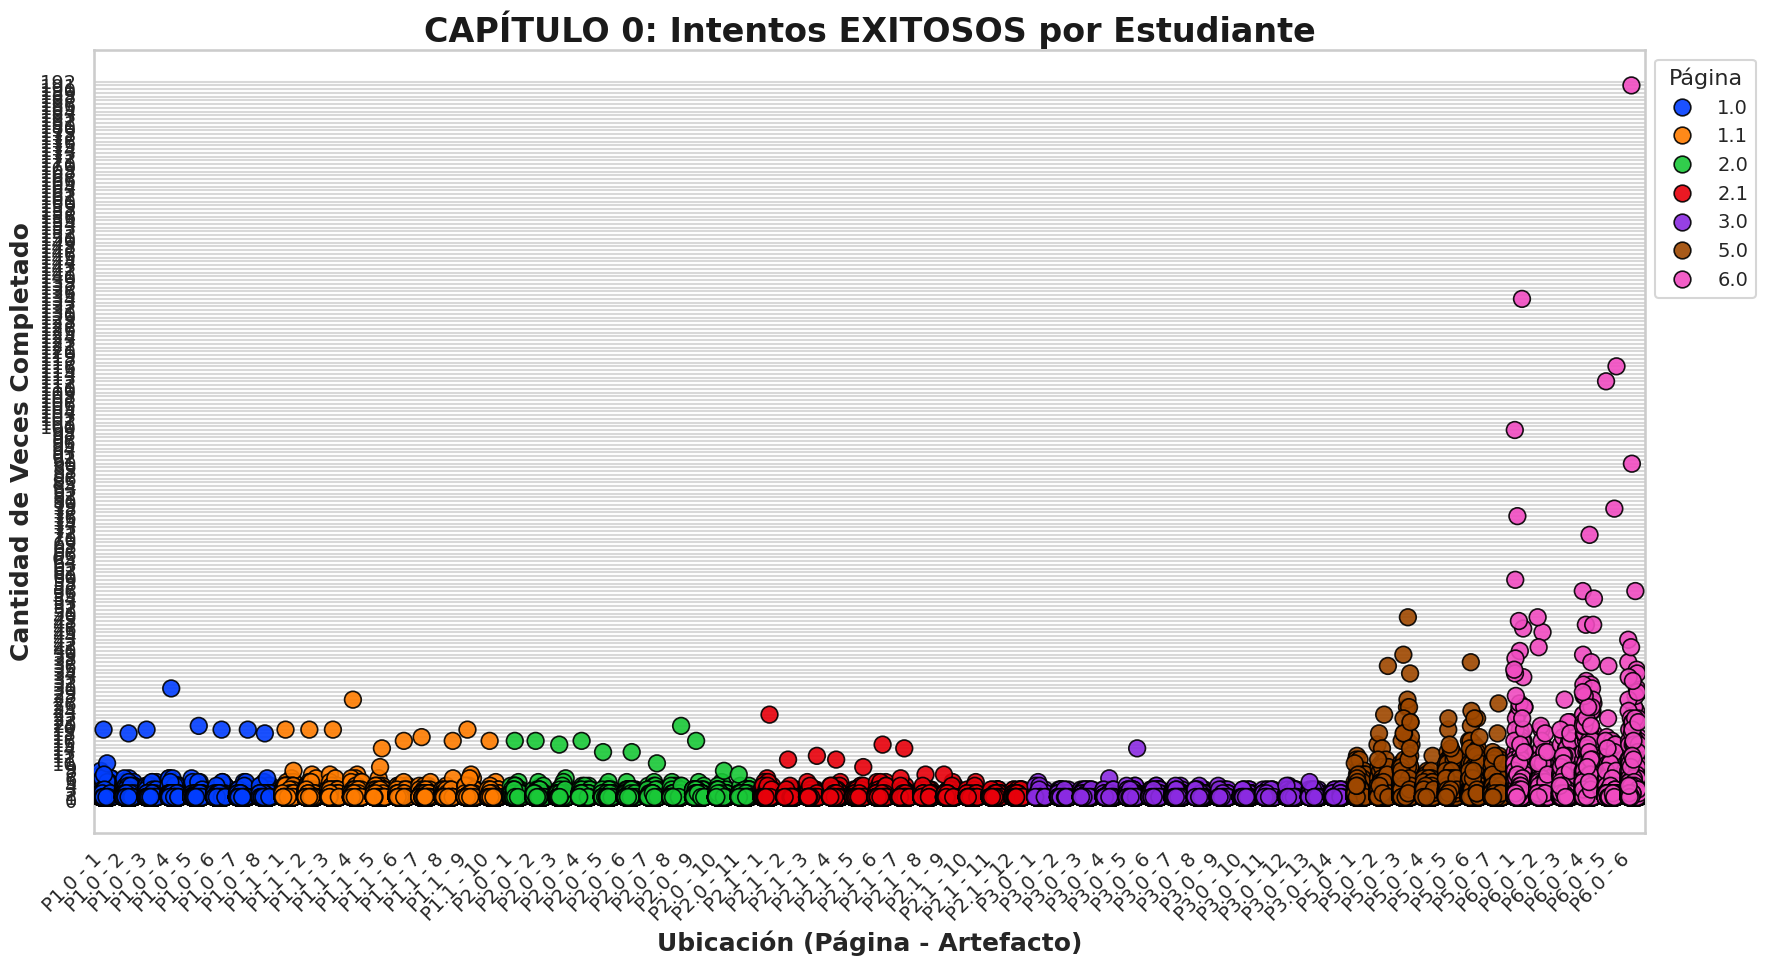

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de datos (Cap 0 - Éxitos)
df_success_0 = droped_df[(droped_df['chapter'] == 0) & (droped_df['validationArtifact'] == True)].copy()
df_counts_s0 = df_success_0.groupby(['_idUser', 'page', 'artifact']).size().reset_index(name='success_count')
df_counts_s0 = df_counts_s0.sort_values(by=['page', 'artifact'])
df_counts_s0['label'] = "P" + df_counts_s0['page'].astype(str) + " - " + df_counts_s0['artifact'].astype(str)

# 2. Configuración de accesibilidad
plt.figure(figsize=(18, 10))
sns.set_context("talk") 

# 3. Gráfica con borde negro (Capítulo 0)
sns.stripplot(
    data=df_counts_s0, 
    x='label', 
    y='success_count', 
    hue='page', 
    jitter=0.25, 
    alpha=0.9, 
    palette='bright', 
    size=12, 
    edgecolor='black', 
    linewidth=1.2
)

# 4. Personalización para vista cansada
plt.title('CAPÍTULO 0: Intentos EXITOSOS por Estudiante', fontsize=24, fontweight='bold', color='#1a1a1a')
plt.xlabel('Ubicación (Página - Artefacto)', fontsize=18, fontweight='bold')
plt.ylabel('Cantidad de Veces Completado', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(range(int(df_counts_s0['success_count'].max()) + 2), fontsize=14) # Eje Y con números enteros claros

plt.legend(title='Página', title_fontsize='16', fontsize='14', bbox_to_anchor=(1, 1))
plt.grid(axis='y', color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

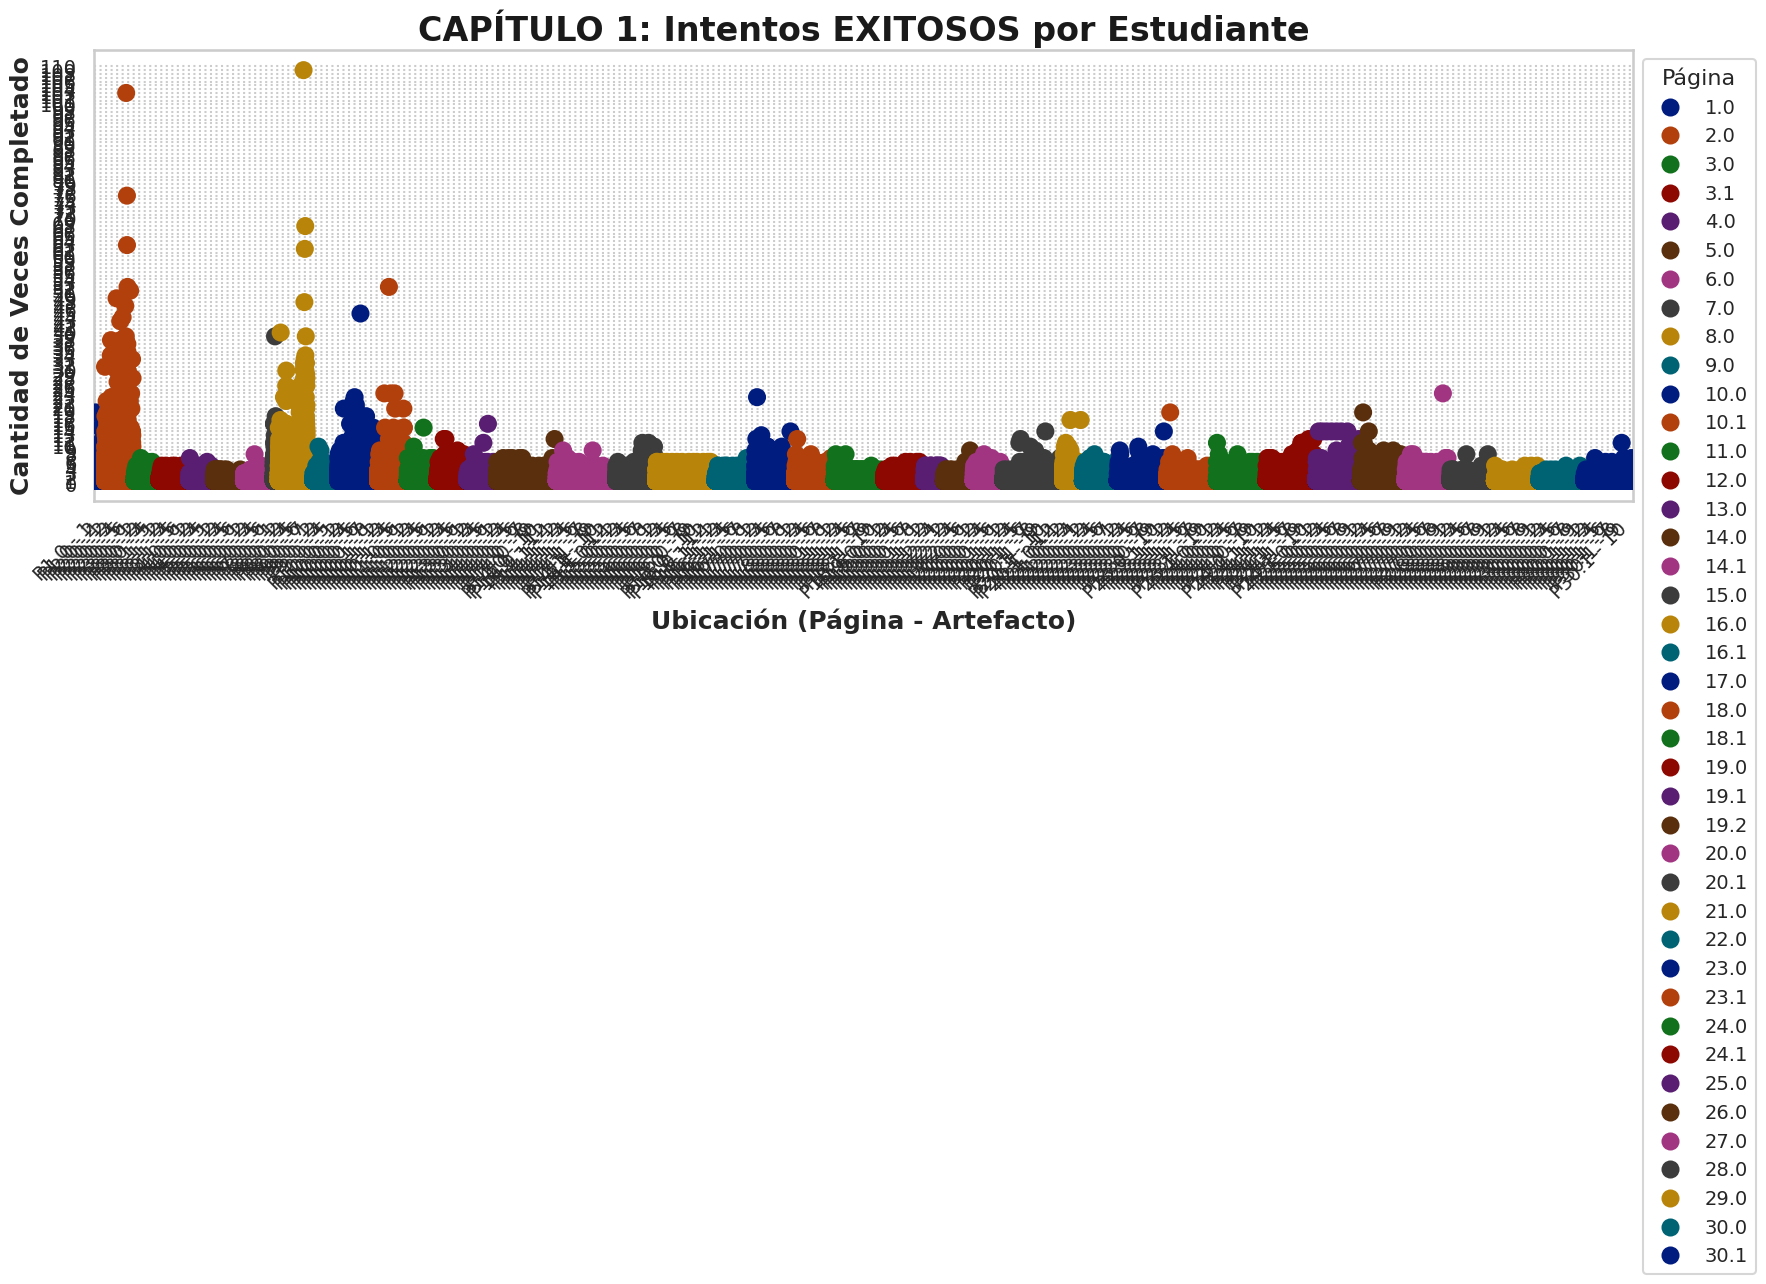

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparación de datos (Cap 1 - Éxitos)
df_success_1 = droped_df[(droped_df['chapter'] == 1) & (droped_df['validationArtifact'] == True)].copy()
df_counts_s1 = df_success_1.groupby(['_idUser', 'page', 'artifact']).size().reset_index(name='success_count')
df_counts_s1 = df_counts_s1.sort_values(by=['page', 'artifact'])
df_counts_s1['label'] = "P" + df_counts_s1['page'].astype(str) + " - " + df_counts_s1['artifact'].astype(str)

# 2. Configuración visual
plt.figure(figsize=(18, 10))
sns.set_context("talk")

# 3. Gráfica SIN borde negro (Capítulo 1)
sns.stripplot(
    data=df_counts_s1, 
    x='label', 
    y='success_count', 
    hue='page', 
    jitter=0.3, 
    alpha=1.0,           # Color 100% sólido para compensar la falta de borde
    palette='dark',      # Colores muy fuertes
    size=13,             # Ligeramente más grande para compensar la falta de borde
    linewidth=0          # Sin borde
)

# 4. Textos de alto contraste
plt.title('CAPÍTULO 1: Intentos EXITOSOS por Estudiante', fontsize=24, fontweight='bold', color='#1a1a1a')
plt.xlabel('Ubicación (Página - Artefacto)', fontsize=18, fontweight='bold')
plt.ylabel('Cantidad de Veces Completado', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(range(int(df_counts_s1['success_count'].max()) + 2), fontsize=14)

plt.legend(title='Página', title_fontsize='16', fontsize='14', bbox_to_anchor=(1, 1))
plt.grid(axis='y', color='black', linestyle=':', alpha=0.2)

plt.tight_layout()
plt.show()

Generando análisis del Capítulo 0...


/tmp/ipykernel_16194/3294813060.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


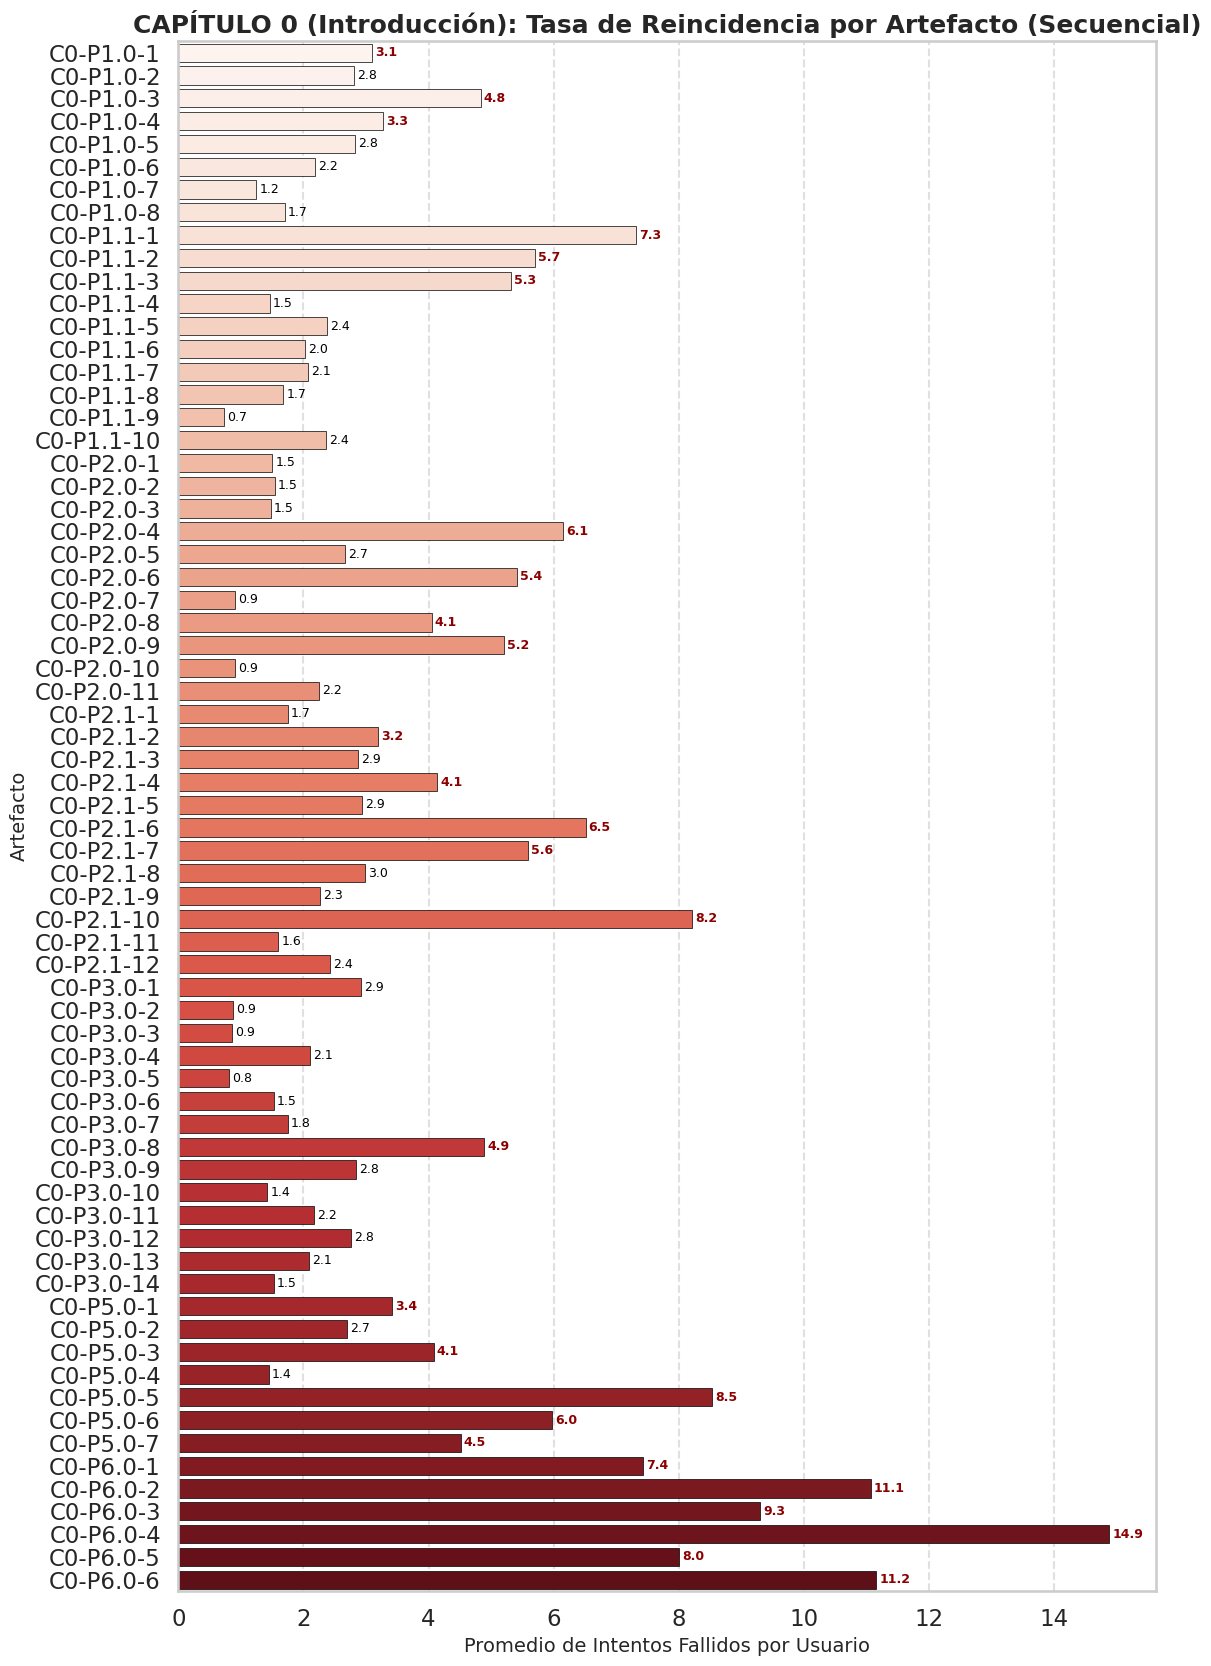

Generando análisis del Capítulo 1...


/tmp/ipykernel_16194/3294813060.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


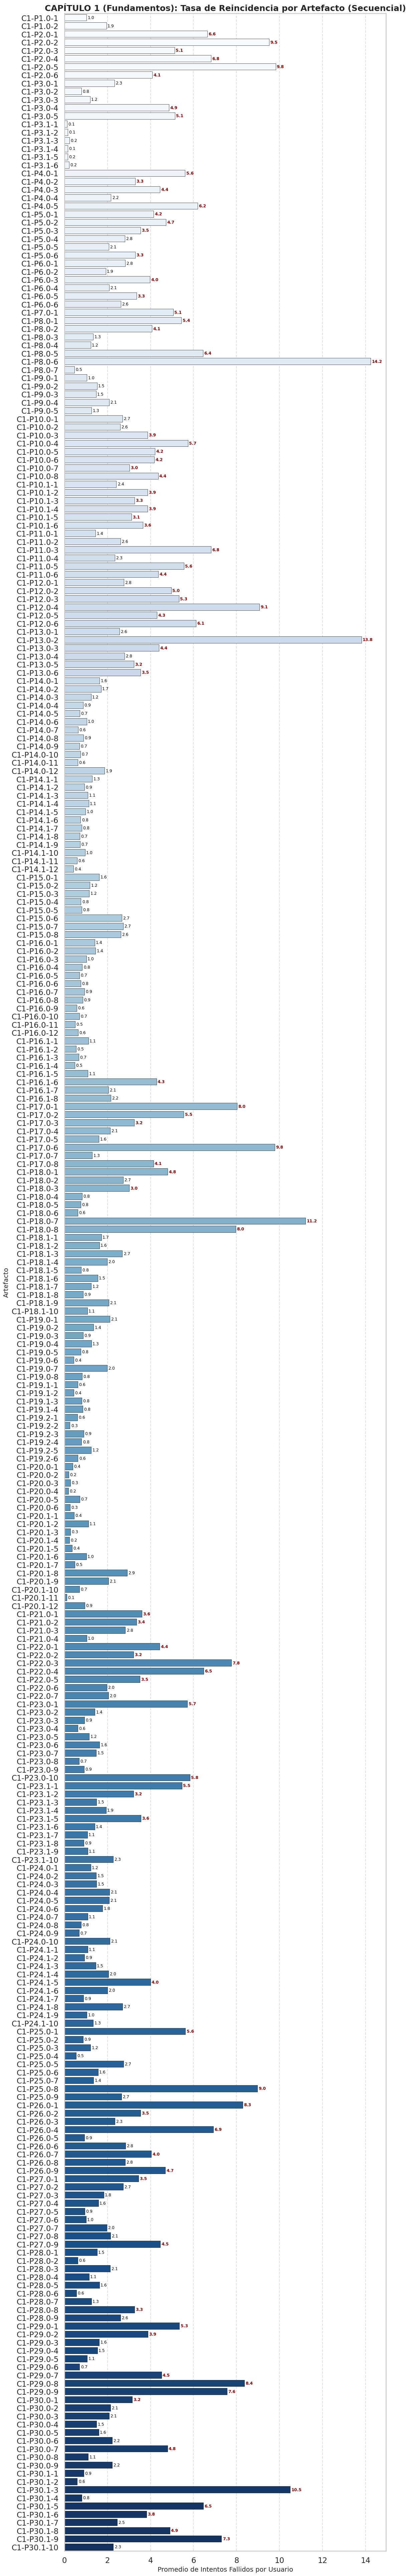

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. FUNCIÓN DE ORDENAMIENTO (NATURAL)
def parse_label_key(label):
    try:
        match = re.search(r'-P([\d\.]+)-(\d+)', str(label))
        if match:
            return (float(match.group(1)), int(match.group(2)))
    except:
        pass
    return (0, 0)

# 2. PREPARACIÓN DE DATOS (Separados y Ordenados)
# Capítulo 0
df_c0_sorted = difficulty_table[difficulty_table['chapter'] == 0].copy()
df_c0_sorted['sort_key'] = df_c0_sorted['label'].apply(parse_label_key)
df_c0_sorted = df_c0_sorted.sort_values(by='sort_key')

# Capítulo 1
df_c1_sorted = difficulty_table[difficulty_table['chapter'] == 1].copy()
df_c1_sorted['sort_key'] = df_c1_sorted['label'].apply(parse_label_key)
df_c1_sorted = df_c1_sorted.sort_values(by='sort_key')

# 3. CÁLCULO DE ALTURA DINÁMICA
# Ajustamos la altura de cada figura independientemente según la cantidad de barras
height_c0 = max(6, len(df_c0_sorted) * 0.25)
height_c1 = max(6, len(df_c1_sorted) * 0.25)

# 4. FUNCIÓN GENERADORA DE FIGURAS INDIVIDUALES
def plot_chapter_figure(data, chapter_name, color_palette, figsize):
    plt.figure(figsize=figsize) # Crea una NUEVA figura cada vez
    ax = sns.barplot(
        data=data,
        x='tasa_reincidencia',
        y='label',
        palette=color_palette,
        edgecolor='black',
        linewidth=0.5
    )
    plt.title(f'{chapter_name}: Tasa de Reincidencia por Artefacto (Secuencial)', fontsize=18, fontweight='bold')
    plt.xlabel('Promedio de Intentos Fallidos por Usuario', fontsize=14)
    plt.ylabel('Artefacto', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)   
   

    # Etiquetas de valor
    for i, v in enumerate(data['tasa_reincidencia']):
        color_text = 'black' if v < 3 else '#8B0000' # Rojo oscuro si es crítico
        weight = 'normal' if v < 3 else 'bold'
        ax.text(v + 0.05, i, f'{v:.1f}', va='center', fontsize=9, color=color_text, fontweight=weight)
    
    plt.tight_layout()
    plt.show() # Muestra la figura actual y cierra el contexto

# --- GENERACIÓN DE IMÁGENES ---

# IMAGEN 1: CAPÍTULO 0
print("Generando análisis del Capítulo 0...")
plot_chapter_figure(df_c0_sorted, "CAPÍTULO 0 (Introducción)", "Reds", (12, height_c0))

# IMAGEN 2: CAPÍTULO 1
print("Generando análisis del Capítulo 1...")
plot_chapter_figure(df_c1_sorted, "CAPÍTULO 1 (Fundamentos)", "Blues", (12, height_c1))


In [32]:
from sklearn.preprocessing import MinMaxScaler

# 1. Métrica de Impacto (Producto)
# Representa el "tiempo total perdido en reintentos" por usuario promedio
difficulty_table['impacto_tiempo'] = difficulty_table['tasa_reincidencia'] * difficulty_table['tiempo_promedio']

# 2. Índice Compuesto Normalizado (Score 0-100)
scaler = MinMaxScaler()
# Normalizamos ambas columnas para que estén en la misma escala (0 a 1)
normalized = scaler.fit_transform(difficulty_table[['tasa_reincidencia', 'tiempo_promedio']])

# Creamos el índice (50% peso a cada factor)
difficulty_table['indice_dificultad'] = (normalized[:, 0] * 0.5 + normalized[:, 1] * 0.5) * 100

# Mostrar los más difíciles según el nuevo índice
top_combined = difficulty_table.sort_values('indice_dificultad', ascending=False).head(10)
styled_combined = top_combined.style.background_gradient(cmap='Reds', subset=['indice_dificultad', 'impacto_tiempo'])
styled_combined

In [33]:
# ---------------------------------------------------------
# ANÁLISIS DE DIFICULTAD (SOLO FALLOS)
# ---------------------------------------------------------

# 1. Denominador: Total de usuarios expuestos al artefacto
#    (Calculamos cuántos usuarios pasaron por cada ejercicio, sin importar si acertaron o fallaron)
total_users_per_artifact = droped_df.groupby('label')['_idUser'].nunique().reset_index(name='total_usuarios')

# 2. Numerador: Solo intentos fallidos
#    Filtramos el dataset original para quedarnos solo con validationArtifact == False
failures_df = droped_df[droped_df['validationArtifact'] == False].copy()

#    Agregamos: Total de fallos y Tiempo promedio invertido en esos fallos
failures_agg = failures_df.groupby('label').agg(
    total_fallos=('label', 'count'),
    tiempo_promedio_fallo=('minutes', 'mean')
).reset_index()

# 3. Combinar tablas (Left Join)
#    Unimos para tener en una sola fila la exposición total y los fallos específicos
metrics_df = pd.merge(total_users_per_artifact, failures_agg, on='label', how='left')

#    Llenamos con 0 los artefactos que no tuvieron fallos (NaN)
metrics_df = metrics_df.fillna({'total_fallos': 0, 'tiempo_promedio_fallo': 0})

# 4. Cálculo de Métricas de "Bloqueo"
#    Tasa: Promedio de errores por cada alumno que intentó el ejercicio
metrics_df['tasa_fallo'] = metrics_df['total_fallos'] / metrics_df['total_usuarios']

#    Impacto: Minutos totales "perdidos" en errores por un usuario promedio
metrics_df['impacto_tiempo_fallo'] = metrics_df['tasa_fallo'] * metrics_df['tiempo_promedio_fallo']

# 5. Ranking Normalizado (Índice de Bloqueo 0-100)
#    Creamos una función simple para normalizar columnas de 0 a 1
def min_max_scale(series):
    if series.max() == series.min(): return 0
    return (series - series.min()) / (series.max() - series.min())

#    Ponderamos 50% la frecuencia del error y 50% la duración del error
norm_tasa = min_max_scale(metrics_df['tasa_fallo'])
norm_tiempo = min_max_scale(metrics_df['tiempo_promedio_fallo'])

metrics_df['indice_bloqueo'] = (norm_tasa * 0.5 + norm_tiempo * 0.5) * 100

# 6. Visualización del TOP 10
print("=== TOP 10 ARTEFACTOS POR ÍNDICE DE BLOQUEO (Dificultad Pura) ===")
top_blocking = metrics_df.sort_values('indice_bloqueo', ascending=False).head(10)

#    Aplicamos estilo (Heatmap) para resaltar los valores críticos
styled_blocking = top_blocking.style.background_gradient(
    subset=['indice_bloqueo', 'impacto_tiempo_fallo'],
    cmap='Reds'
).format({
    'tasa_fallo': '{:.2f}',
    'tiempo_promedio_fallo': '{:.2f} min',
    'impacto_tiempo_fallo': '{:.2f} min',
    'indice_bloqueo': '{:.1f}'
})

styled_blocking

=== TOP 10 ARTEFACTOS POR ÍNDICE DE BLOQUEO (Dificultad Pura) ===


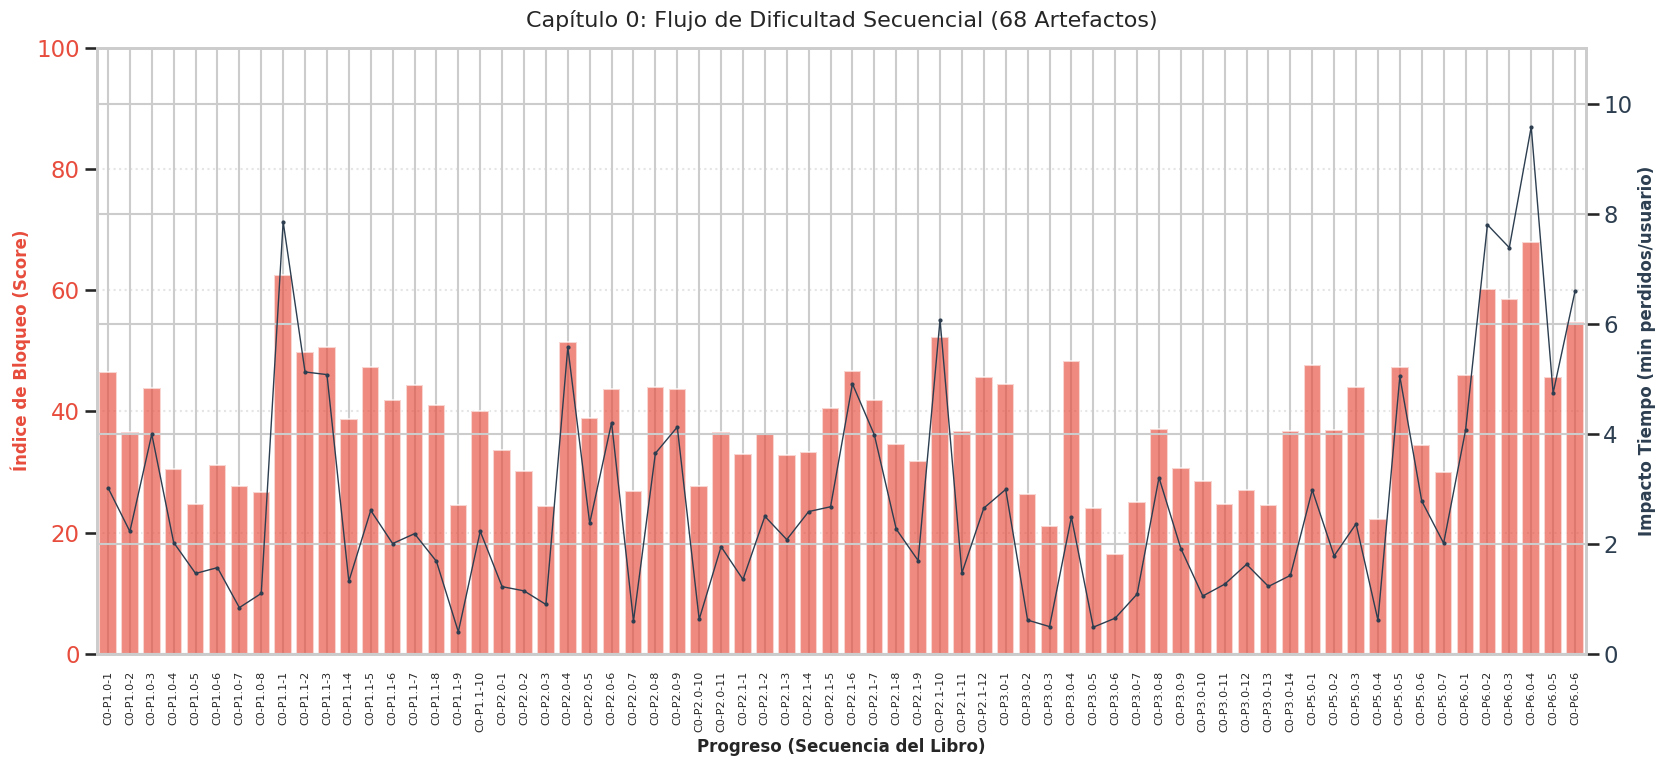

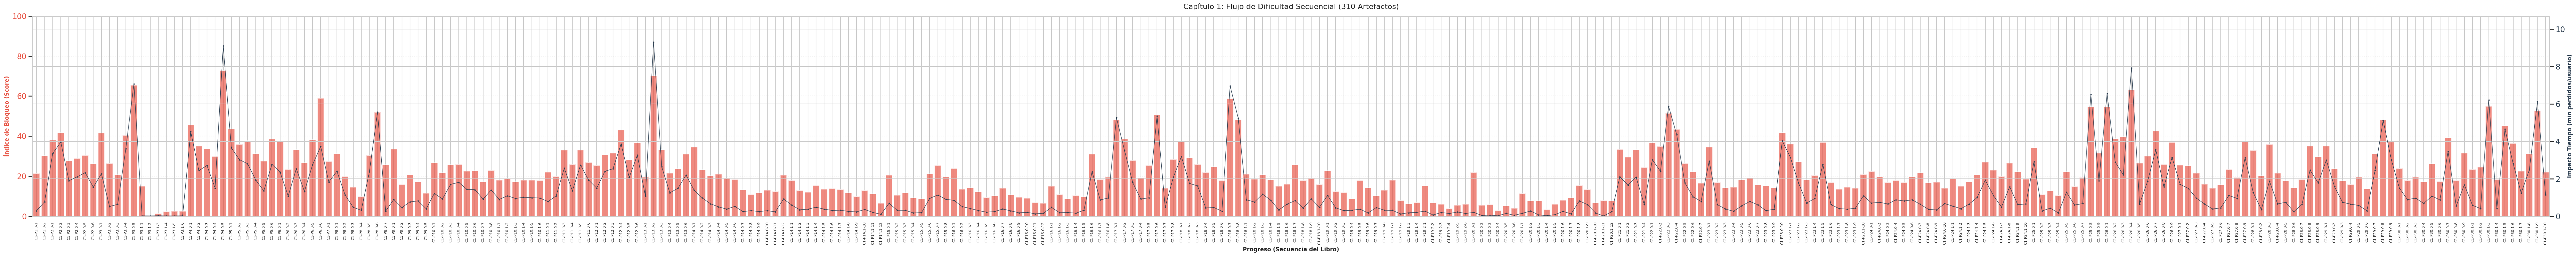

In [36]:
# -------------------------------------------------------------------------
# VISUALIZACIÓN SECUENCIAL (FLUJO DEL ESTUDIANTE)
# -------------------------------------------------------------------------

# 1. Asegurar que tenemos las columnas numéricas para ordenar
#    Extraemos capítulo, página y artefacto del label si no existen
metrics_df['chapter_num'] = metrics_df['label'].apply(lambda x: int(x.split('-')[0].replace('C', '')))
metrics_df['page_num'] = metrics_df['label'].apply(lambda x: float(re.search(r'P([\d.]+)', x).group(1)))
metrics_df['artifact_num'] = metrics_df['label'].apply(lambda x: int(x.split('-')[-1]))

# 2. Ordenar explícitamente por la secuencia del libro
metrics_df = metrics_df.sort_values(by=['chapter_num', 'page_num', 'artifact_num'], ascending=[True, True, True])

chapters = sorted(metrics_df['chapter_num'].unique())

for cap in chapters:
    # Filtrar datos del capítulo (ya ordenados)
    cap_data = metrics_df[metrics_df['chapter_num'] == cap]
    
    if cap_data.empty: continue

    # Ancho dinámico
    plot_width = max(14, len(cap_data) * 0.25)
    
    fig, ax1 = plt.subplots(figsize=(plot_width, 8))
    
    # --- EJE PRINCIPAL (Izquierdo): Índice de Bloqueo ---
    color_bar = '#e74c3c' 
    ax1.bar(
        range(len(cap_data)), 
        cap_data['indice_bloqueo'], 
        color=color_bar, 
        alpha=0.65, 
        width=0.8,
        label='Índice de Bloqueo (0-100)'
    )
    
    ax1.set_xlabel('Progreso (Secuencia del Libro)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Índice de Bloqueo (Score)', color=color_bar, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_bar)
    ax1.set_ylim(0, 100)
    
    # Etiquetas Eje X
    ax1.set_xticks(range(len(cap_data)))
    ax1.set_xlim(-0.5, len(cap_data) - 0.5)
    ax1.set_xticklabels(cap_data['label'], rotation=90, ha='center', fontsize=8) 
    
    # --- EJE SECUNDARIO (Derecho): Impacto de Tiempo ---
    ax2 = ax1.twinx()
    color_line = '#2c3e50' 
    
    ax2.plot(
        range(len(cap_data)), 
        cap_data['impacto_tiempo_fallo'], 
        color=color_line, 
        marker='.', 
        linewidth=1, 
        markersize=4, 
        label='Impacto Tiempo (min)'
    )
    
    ax2.set_ylabel('Impacto Tiempo (min perdidos/usuario)', color=color_line, fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_line)
    
    max_time = cap_data['impacto_tiempo_fallo'].max()
    ax2.set_ylim(0, max_time * 1.15 if max_time > 0 else 1) 
    
    plt.title(f'Capítulo {cap}: Flujo de Dificultad Secuencial ({len(cap_data)} Artefactos)', fontsize=16, pad=15)
    ax1.grid(axis='y', linestyle=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()